In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import xgboost as xgb
import random

import pickle

from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.preprocessing import RobustScaler,minmax_scale,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,GroupKFold,StratifiedKFold,StratifiedGroupKFold
from sklearn.metrics import classification_report, mean_squared_error as MSE,roc_auc_score,confusion_matrix,f1_score,ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric

import warnings
warnings.filterwarnings("ignore")

## **Introduction.**

Data analysis revealed the need to split wells into different datasets with varying sets of features. Individual models must be built for each dataset. Given our limited experience working with time series data, we opted for classic machine learning methods. However, our interest in this area remains, and further investigation of this dataset is planned when time allows.

### **1. Description of the dataset**

The dataset includes measurements from multiple sensors and instruments, including:

WELLNAME: Unique identifier for each borehole (string)

DEPT: Depth of measurement (analogous to time) (numeric)

TARGET: Segment labels for the time series data (string)

DENS and DEN: Density logs (g/cm³) (numeric)

DT and SONIC: Acoustic logging data (us/ft) (numeric)

FLGR and GR: Gamma logging data (radiation measurements) (gAPI) (numeric)

CALI and CAL: Calliper log data (inches) (numeric)

RESD and RES_DEP: Electrical resistance logs (ohm*m) (numeric)


In [6]:
df1 = pd.read_csv('/kaggle/input/test-df/groningen_test.csv')
df1.head()

,DEPT,DENS,DEN,DT,SON,FLGR,GR,CALI,CAL,RESD,RES_DEP,WELLNAME,target
0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,AMR-1,NaN
1,0.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,AMR-1,NaN
2,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,AMR-1,NaN
3,1.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,AMR-1,NaN
4,2.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,AMR-1,NaN


<Axes: >

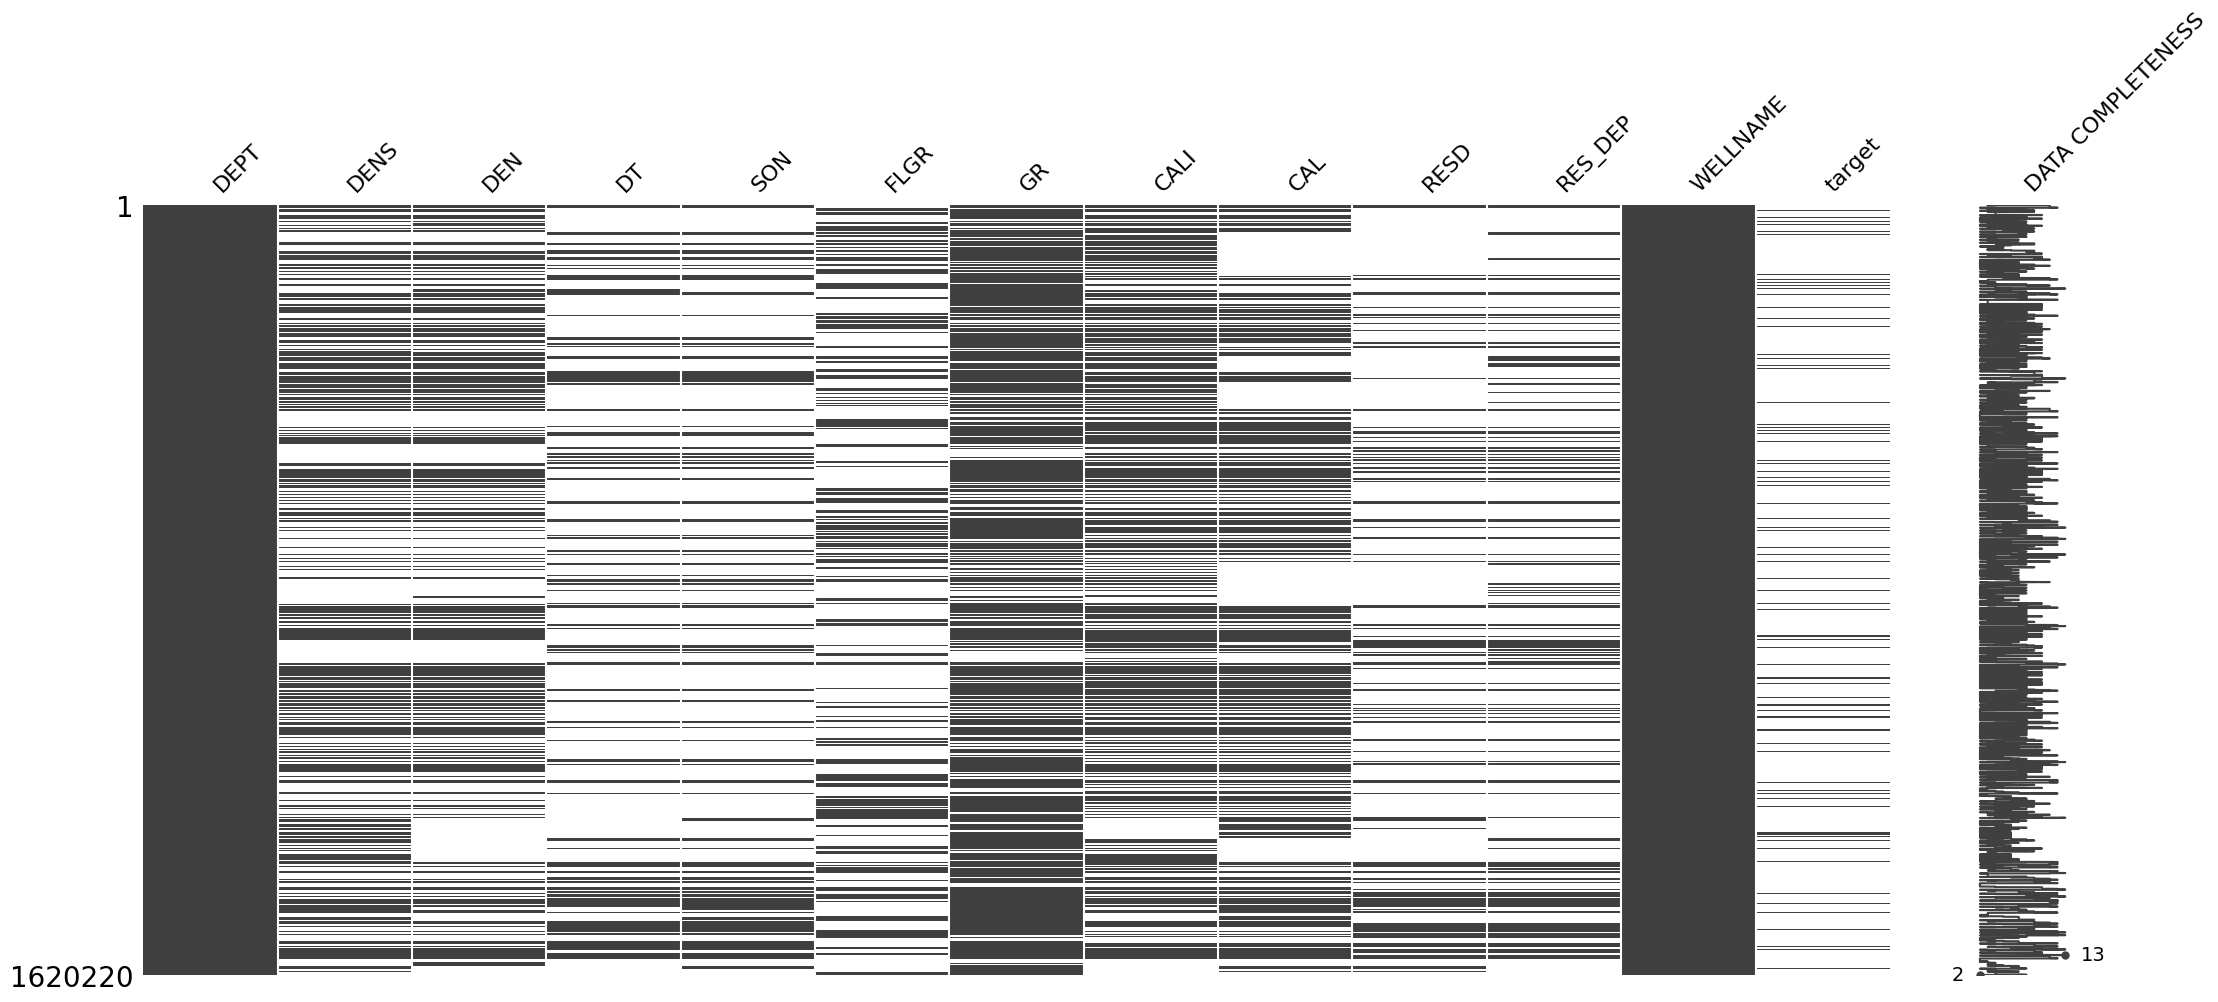

In [7]:
msno.matrix(df1, labels=True)


In [8]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
DEPT,1620220.0,1754.147744,872.776812,0.000000,1054.400033,1889.320154,2459.508148,4649.987202
DENS,747617.0,2.276505,0.262962,0.974000,2.085185,2.151256,2.488000,3.129130
DEN,689497.0,-1.206745,186.560597,-9999.000000,2.084000,2.150000,2.483999,3.100694
DT,381899.0,88.948730,32.671687,15.766000,68.154129,76.667244,95.651283,818.229980
SON,397839.0,88.782977,32.524313,15.766000,68.173908,76.603462,95.401955,818.229980
FLGR,561170.0,0.302290,0.459200,0.000000,0.000000,0.000000,1.000000,1.000000
GR,1218378.0,33.471632,32.789365,-2.427295,11.023840,19.045359,46.150964,686.233398
CALI,938292.0,11.538250,3.541366,-0.080793,9.878000,10.416748,12.103077,36.213814
CAL,775905.0,11.626421,3.516136,-0.080793,9.872221,10.450734,12.325281,40.175247
RESD,341835.0,1686.824420,5620.062118,-0.144000,1.260508,5.401033,1413.899475,99739.312500


In [9]:
((df1.DEN/df1.DENS)).value_counts()

1.0    668927
Name: count, dtype: int64

In [10]:
df1[df1.DEN==df1.DEN.min()].head(2)
df1.replace(-9999.0,np.NaN,inplace = True)
df1.replace(df1['RES_DEP'].max(),np.NaN,inplace = True)
names = df1.WELLNAME.unique()


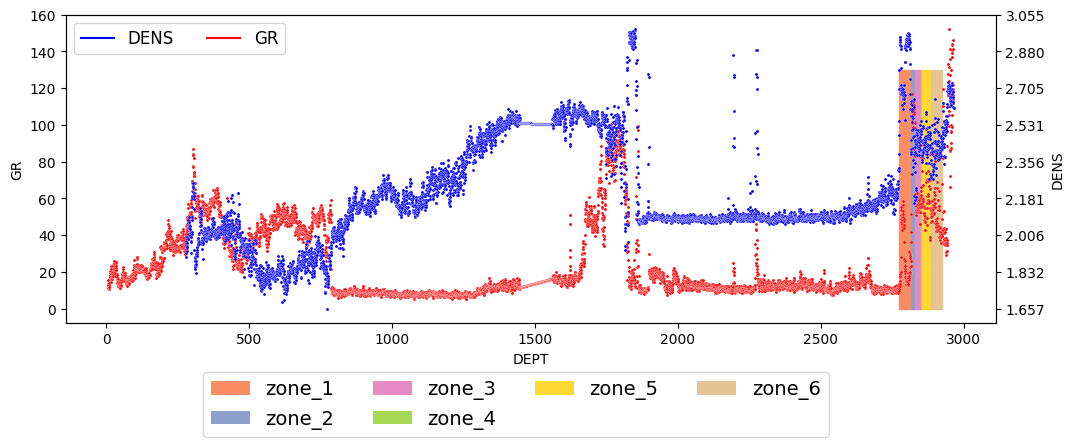

In [11]:

name = names[0]
fig, axn = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 4))

well = df1[df1.WELLNAME == name]
for i in range(len(well.target.unique())):
    if well.target.unique()[i] is not None:
        start_depth = well[well.target == well.target.unique()[i]]['DEPT'].min()
        end_depth = well[well.target == well.target.unique()[i]]['DEPT'].max()
        axn.fill_between(
            [start_depth, end_depth], [0,0], [130,130],
            color = sns.color_palette('Set2', 9)[i]
        )

axn.set(xlabel = None)

ax1 = axn.twinx()
sns.scatterplot(
    data=df1[df1.WELLNAME == name], x='DEPT', y='GR',ax=axn, color='red', s=5   
)
sns.scatterplot(
    data=df1[df1.WELLNAME == name], x='DEPT', y='DENS', ax=ax1, color='blue', s=5
)

ylim1 = axn.get_ylim()
len1 = ylim1[1]-ylim1[0]
yticks1 = axn.get_yticks()
rel_dist = [(y-ylim1[0])/len1 for y in yticks1]
ylim2 = ax1.get_ylim()
len2 = ylim2[1]-ylim2[0]
yticks2 = [ry*len2+ylim2[0] for ry in rel_dist]

ax1.set_yticks(yticks2)
ax1.set_ylim(ylim2)

axn.legend(handles=[
    Line2D([], [], marker='', color='blue', label='DENS'),
    Line2D([], [], marker='', color='red', label='GR')
], fontsize = 12, ncol = 2)



legend_elements = [Patch(facecolor = sns.color_palette('Set2', 9)[i], label = f'zone_{i}') for i in range(len(well.target.unique()))]

fig.legend(handles = legend_elements[1:], loc ='lower center', fontsize = 14,
            bbox_to_anchor = (0, -0.2, 1, 1) ,ncol = 4)

In [12]:
print('DENS-DEN = ',(df1.DENS-df1.DEN).sum())
print('')
print('DEN/DENS =' ,(df1.DEN/df1.DENS).value_counts())
print('')
display(df1.isna().sum())

DENS-DEN =  0.0

DEN/DENS = 1.0    668927
Name: count, dtype: int64



DEPT              0
DENS         872603
DEN          930963
DT          1238321
SON         1222381
FLGR        1059050
GR           401842
CALI         681928
CAL          844315
RESD        1278385
RES_DEP     1214764
WELLNAME          0
target      1463260
dtype: int64

We see that **the measurements made by different sensors are the same**, the only difference is only in the number of missing values.

In [13]:
df = df1[['DEPT','target','WELLNAME','FLGR','GR']]

In [14]:
df['DEN'] = df1[['DENS','DEN']].mean(axis=1)
df['DT'] = df1[['DT','SON']].mean(axis=1)
df['CAL'] = df1[['CALI','CAL']].mean(axis=1)
df['RESD'] = df1[['RESD','RES_DEP']].mean(axis=1)

Not seeing the difference between the sensor measurements, I decided to average them, thereby getting rid of several omissions in the measurements. I do not yet know how this will affect the result, but I will carry out all further actions with the new dataset. Of course, feedback from the company or a more extensive description of the dataset would be beneficial. But in our case, we just keep going on.

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DEPT,1620220.0,1754.147744,872.776812,0.000000,1054.400033,1889.320154,2459.508148,4649.987202
FLGR,561170.0,0.302290,0.459200,0.000000,0.000000,0.000000,1.000000,1.000000
GR,1218378.0,33.471632,32.789365,-2.427295,11.023840,19.045359,46.150964,686.233398
DEN,767947.0,2.276262,0.262812,0.974000,2.085000,2.151044,2.488703,3.129130
DT,405516.0,88.842549,32.586743,15.766000,68.173208,76.635460,95.484833,818.229980
CAL,992056.0,11.686494,3.707527,-0.080793,9.891000,10.458820,12.250964,40.175247
RESD,425411.0,1586.014945,5115.491082,-0.144000,1.478783,7.399215,1560.883484,99739.312500


### **2. Let's do a little data analysis**

In [16]:
def range_col(x):
    return x.max() - x.min()
df_1 = df.groupby(['WELLNAME','target',]).agg({'DEPT': ['min','max',range_col]}).reset_index()


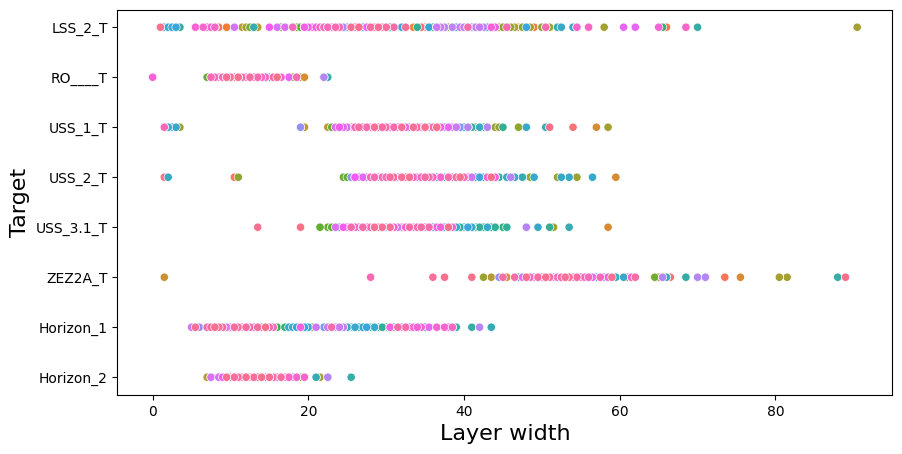

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = df_1, x=('DEPT', 'range_col'), y = ('target', ''),hue = ('WELLNAME', ''),)
plt.xlabel('Layer width',fontsize = 16)
plt.ylabel('Target',fontsize = 16)
ax.legend_.remove()

plt.show()

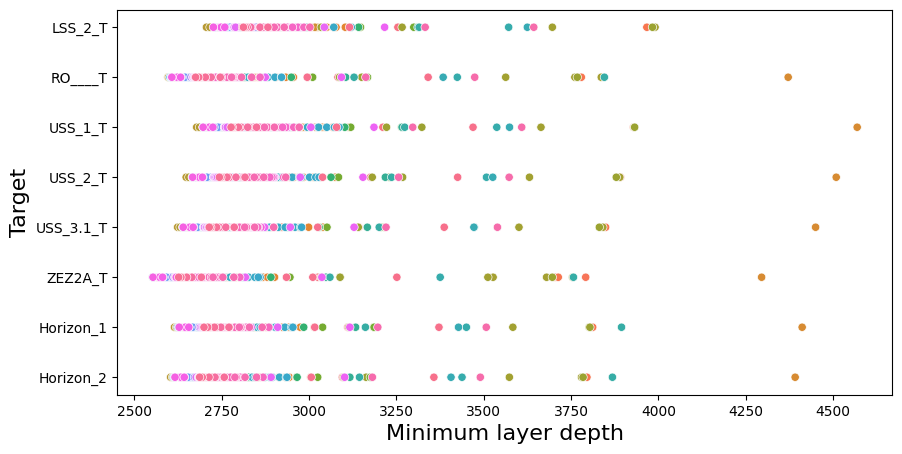

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = df_1, x=('DEPT', 'min'), y = ('target', ''),hue = ('WELLNAME', ''))
ax.legend_.remove()
plt.xlabel('Minimum layer depth',fontsize = 16)
plt.ylabel('Target',fontsize = 16)
plt.show()

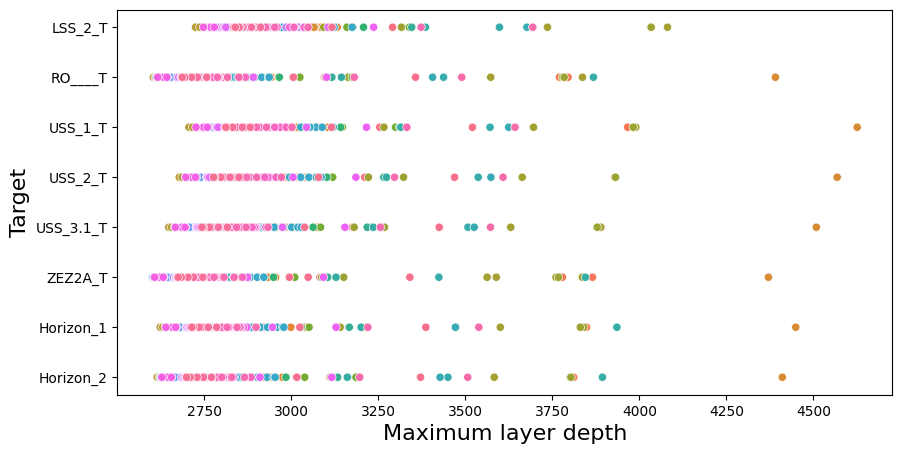

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = df_1, x=('DEPT', 'max'), y = ('target', ''),hue = ('WELLNAME', ''))
ax.legend_.remove()
plt.xlabel('Maximum layer depth',fontsize = 16)
plt.ylabel('Target',fontsize = 16)
plt.show()

We see that the same layers have different widths, the starting point of the layer depth and its maximum. But there is also a similarity in the data, wells with the same letter name have very similar values. Perhaps this is due to their geographical location or there is some other connection with the names.

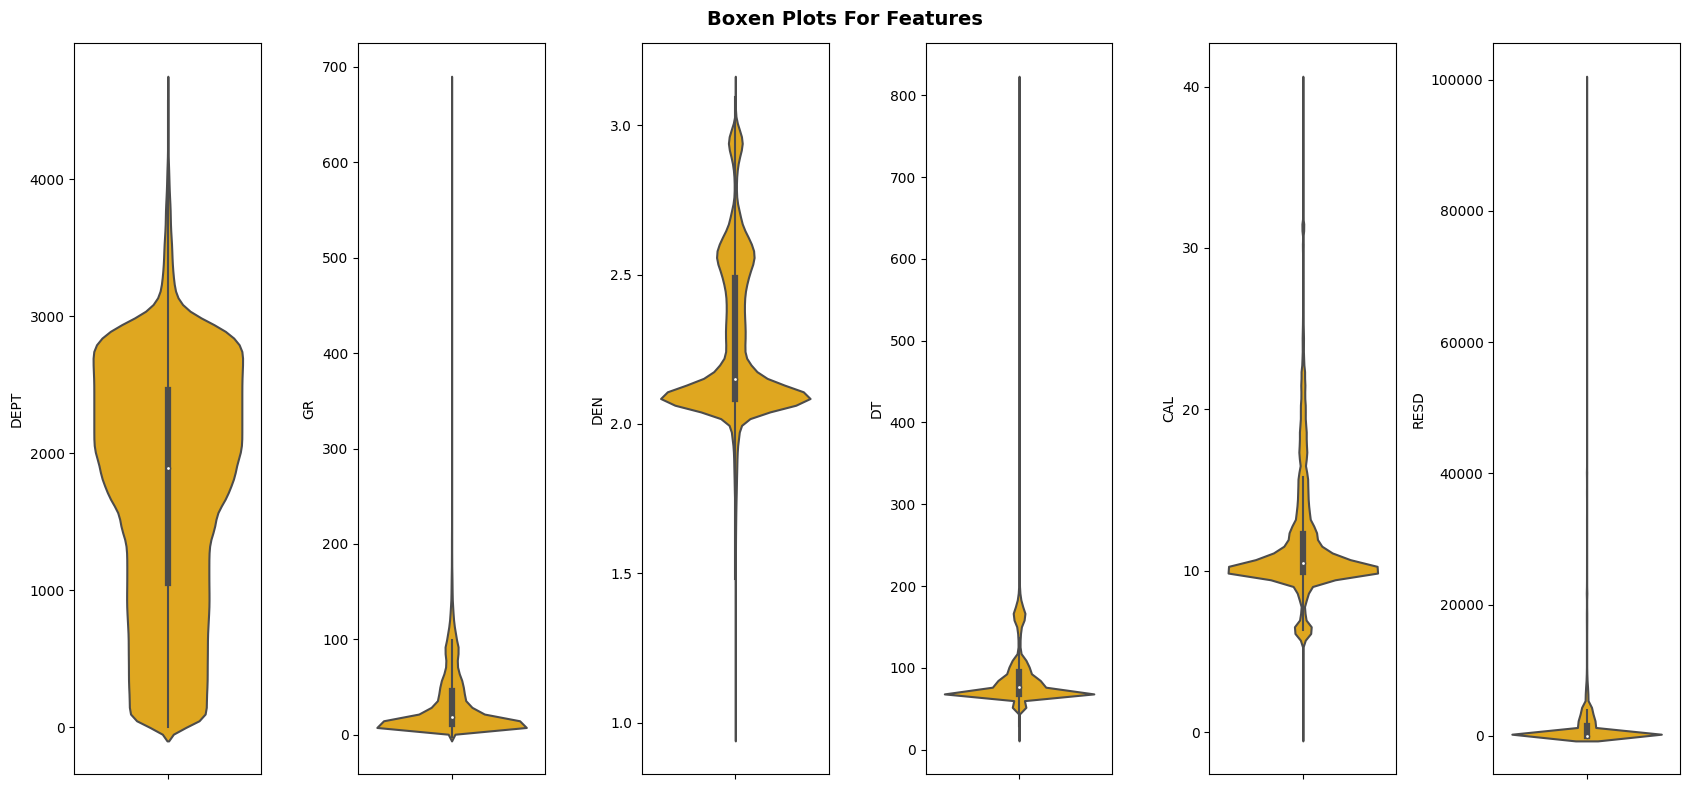

In [20]:
col = ['DEPT', 'GR', 'DEN', 'DT', 'CAL', 'RESD']
_, axes = plt.subplots(1, len(col), figsize = (17,8))

for i, ax in enumerate(axes.flatten()):
    sns.violinplot(y = df[col[i]], color = "#ffb400", ax = axes[i] )

_.suptitle('Boxen Plots For Features', fontsize = 14, fontweight = 'heavy')
plt.tight_layout()
plt.show()

Basically, our data is dominated by information about wells at depths from 1,500 to 3,000 meters. According to the sensor data, it is clear that there are clear boundaries where most of the values are located, but it is also clear that there are values that are many times higher than these values, it can be assumed that these are outliers or measurement errors. During the analysis, two abnormal values were found, which were replaced with NaN. It is proposed to conduct further research by considering information from sensors relative to the target variable.

In [21]:
df.columns = df.columns.str.lower()

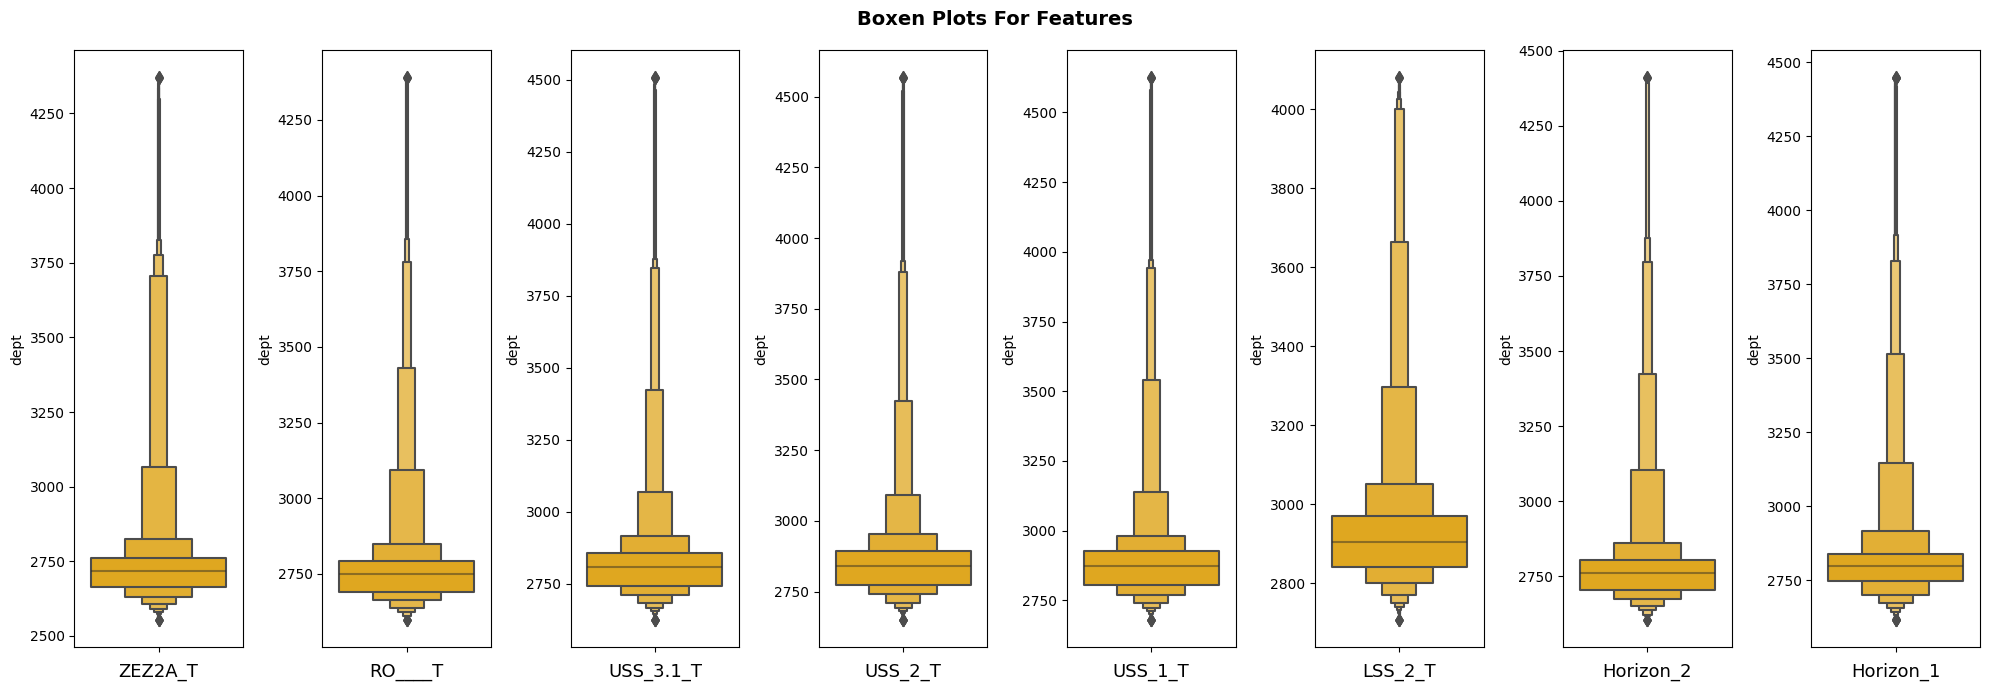

In [22]:
val = df.target.unique().tolist()[1:]
_, axes = plt.subplots(1, len(val), figsize = (20,7))
for i, ax in enumerate(axes.flatten()):
    sns.boxenplot(y = df[df.target ==val[i]].dept, color = "#ffb400", ax = axes[i] )
    axes[i].set_xlabel(val[i], fontsize=13)

_.suptitle('Boxen Plots For Features', fontsize = 14, fontweight = 'heavy')
plt.tight_layout()
plt.show()

Almost all targets have the largest distribution relative to the depth in the area of 2700 - 2800 meters and only the LSS_2_T layer differs from them.

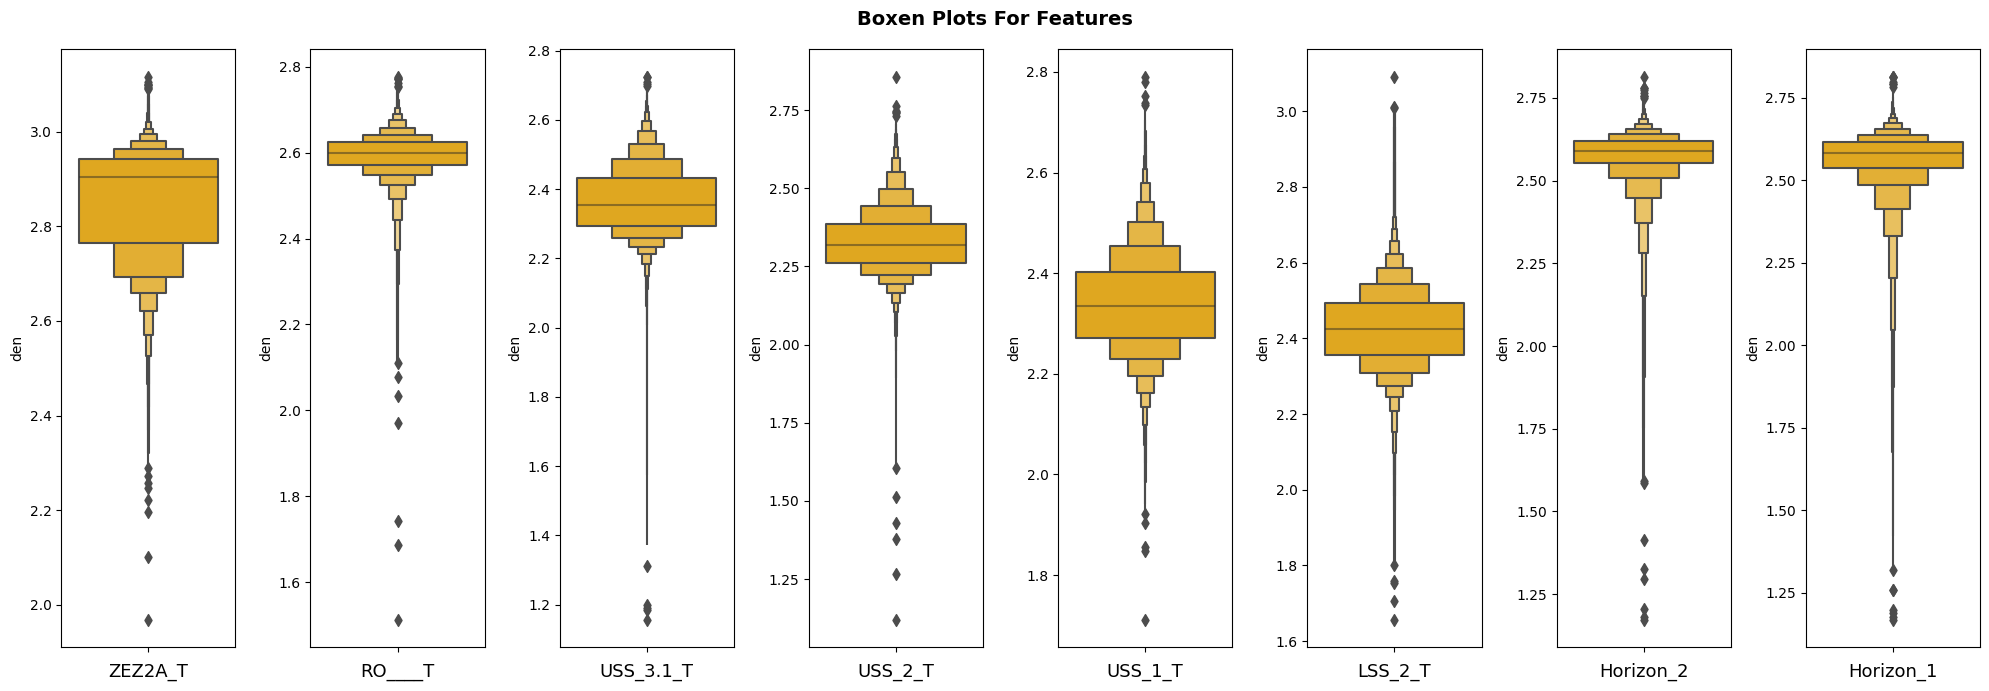

In [23]:
val = df.target.unique().tolist()[1:]
_, axes = plt.subplots(1, len(val), figsize = (20,7))
for i, ax in enumerate(axes.flatten()):
    sns.boxenplot(y = df[df.target ==val[i]].den, color = "#ffb400", ax = axes[i] )
    axes[i].set_xlabel(val[i], fontsize=13)

_.suptitle('Boxen Plots For Features', fontsize = 14, fontweight = 'heavy')
plt.tight_layout()
plt.show()

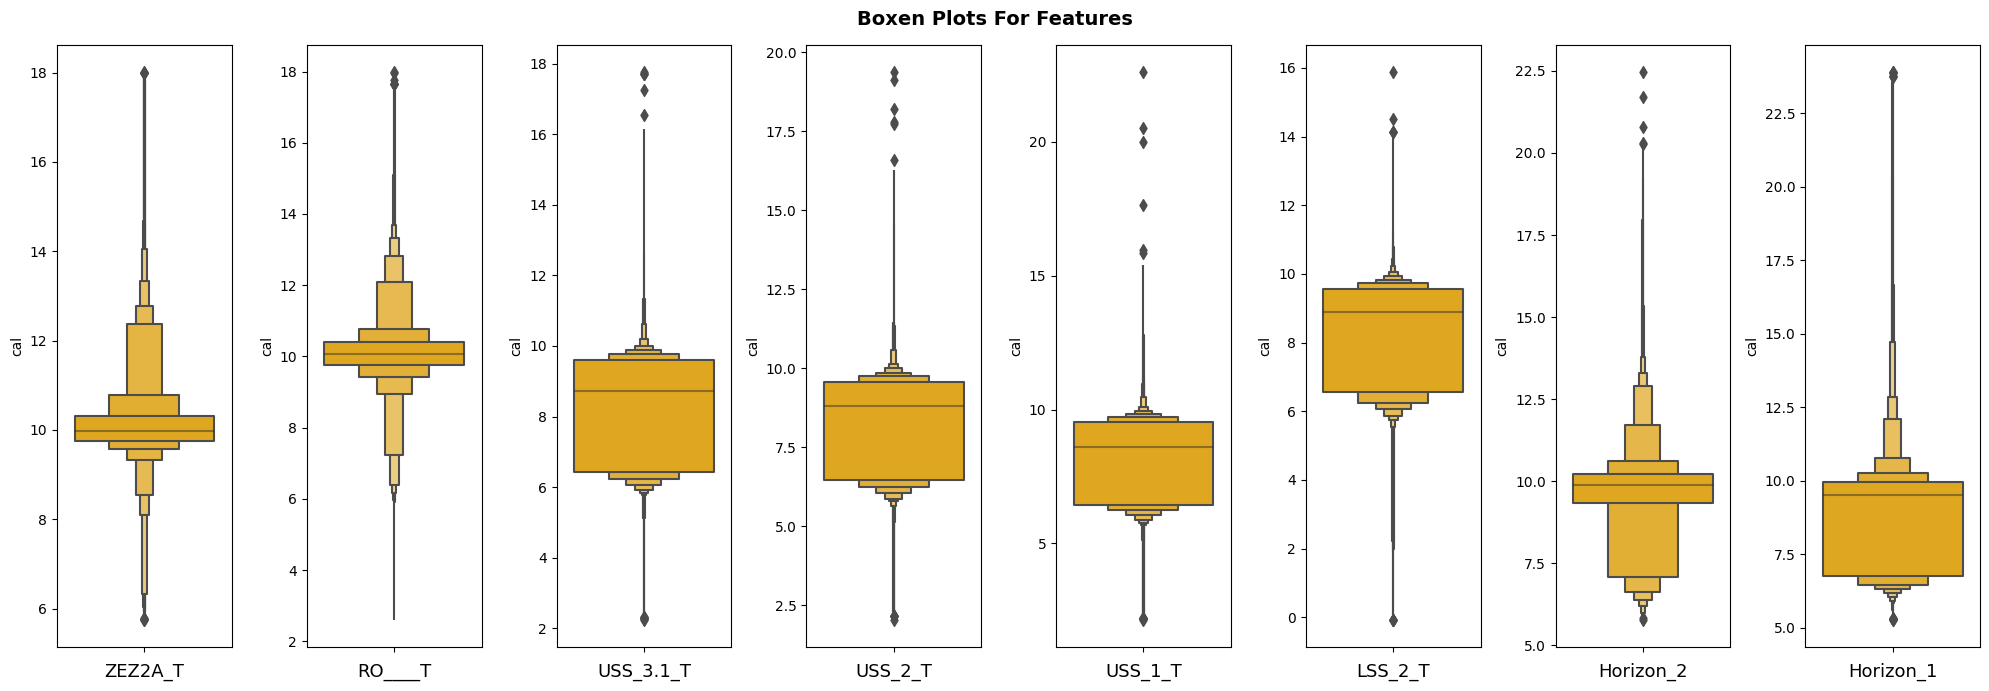

In [24]:
val = df.target.unique().tolist()[1:]
_, axes = plt.subplots(1, len(val), figsize = (20,7))
for i, ax in enumerate(axes.flatten()):
    sns.boxenplot(y = df[df.target ==val[i]].cal, color = "#ffb400", ax = axes[i] )
    axes[i].set_xlabel(val[i], fontsize=13)

_.suptitle('Boxen Plots For Features', fontsize = 14, fontweight = 'heavy')
plt.tight_layout()
plt.show()

Depending on the layer, it can be assumed that it is necessary to introduce additional grouping of wells, which in the future may be useful for the task of multiclass classification. A little pre-processing of the data is required, including the elimination of outliers, as well as making a decision regarding their processing.

In [25]:
labl_enc = LabelEncoder()
df['wellname_code'] = labl_enc.fit_transform(df.wellname.values)
le = pd.get_dummies(df['target']).astype('float32')
df = pd.concat([df, le,],axis=1)


## Generating features


**3. Let's expand the feature** space using feature engineering methods for time series

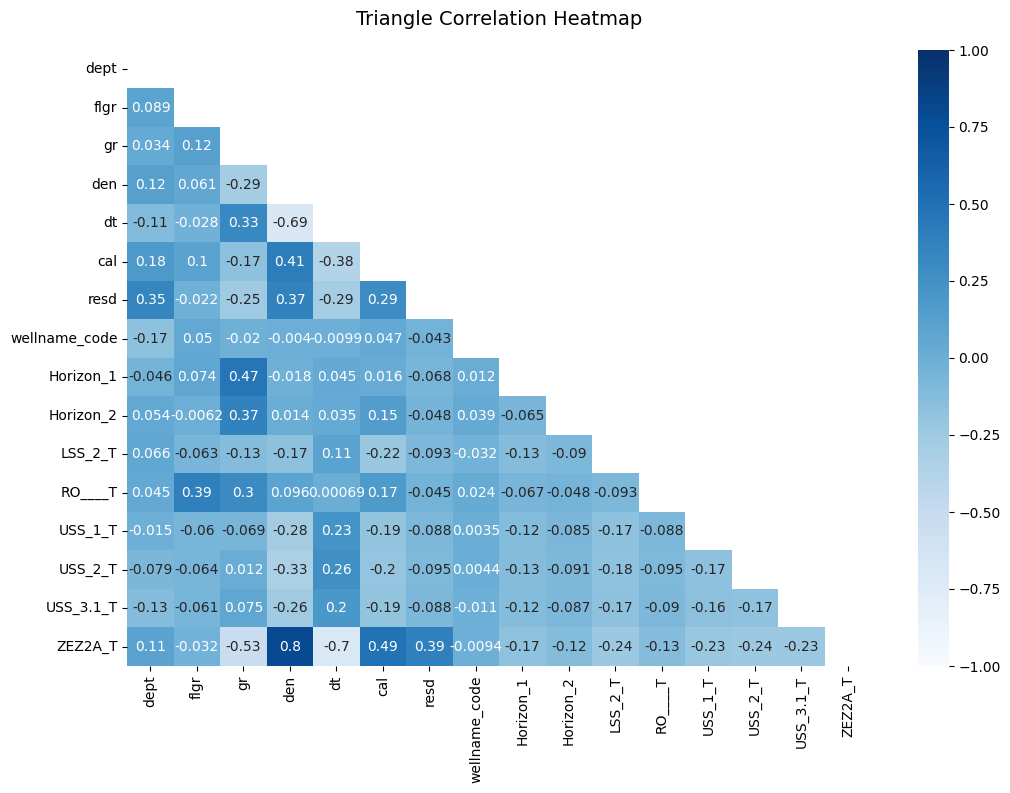

In [26]:
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df.dropna().drop(['target','wellname'],axis = 1).corr()))
heatmap = sns.heatmap(df.dropna().drop(['target','wellname'],axis = 1).corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':14}, pad=18);

In [27]:
df.isna().sum()/len(df)

dept             0.000000
target           0.903124
wellname         0.000000
flgr             0.653646
gr               0.248017
den              0.526023
dt               0.749715
cal              0.387703
resd             0.737436
wellname_code    0.000000
Horizon_1        0.000000
Horizon_2        0.000000
LSS_2_T          0.000000
RO____T          0.000000
USS_1_T          0.000000
USS_2_T          0.000000
USS_3.1_T        0.000000
ZEZ2A_T          0.000000
dtype: float64

In [28]:
df.target.value_counts()

target
ZEZ2A_T      36618
USS_2_T      24449
USS_1_T      22557
USS_3.1_T    22535
LSS_2_T      18700
Horizon_1    14338
Horizon_2     9411
RO____T       8352
Name: count, dtype: int64

There is a significant amount of missing values from the sensors in the data, and in some columns the omissions account for up to 75% of the total number of values. The issue of data purification and possible methods of filling in gaps is difficult due to the lack of understanding of their specifics and the scale of the scales.

In [29]:
df_new = df[~df.index.isin(df.query('target.isna() and gr.isna() and resd.isna() and cal.isna() and dt.isna() and den.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('gr.isna() and resd.isna() and cal.isna() and dt.isna() and den.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('target.isna() and resd.isna() and cal.isna() and dt.isna() and den.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('target.isna() and dt.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('den.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('target.isna() and resd.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('target.isna() and dt.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('target.isna() and cal.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('dt.isna() and resd.isna() and cal.isna()').index.tolist())]
df_new = df_new.dropna(subset = ['gr'])

df_new = df_new.drop('flgr',axis =1).reset_index(drop= True)

# df_new.head()

In [30]:
df_new.isna().sum()/len(df_new)

dept             0.000000
target           0.473118
wellname         0.000000
gr               0.000000
den              0.000000
dt               0.385425
cal              0.001529
resd             0.257301
wellname_code    0.000000
Horizon_1        0.000000
Horizon_2        0.000000
LSS_2_T          0.000000
RO____T          0.000000
USS_1_T          0.000000
USS_2_T          0.000000
USS_3.1_T        0.000000
ZEZ2A_T          0.000000
dtype: float64

We successfully cleaned up the missing data without significantly reducing the number of observations for the target variable. However, there are two columns that are missing from 25 to 38% of the data. Let's try to compete for them using machine learning methods and for a while imagine that our goal will be these two columns.

In [31]:
df_cluster = df_new.groupby(['wellname_code' ]).agg(
                                           max_dept = ('dept','max'),
                                           mean_dept = ('dept','mean'),
                                           min_den = ('den','min'),
                                           max_den = ('den','max'),
                                           mean_den = ('den','mean'),
                                           #mean_cal= ('cal','mean'),
                                           mean_gr= ('gr','mean'),
                                           
                                                    ).reset_index()
df_cluster.head(3)

,wellname_code,max_dept,mean_dept,min_den,max_den,mean_den,mean_gr
0,0,2958.5,1621.00,1.657153,2.988067,2.213420,24.556666
1,1,3060.0,2918.75,2.128264,2.992948,2.497009,56.277998
2,2,2936.0,2814.75,2.129000,2.939000,2.468514,64.875315


In [32]:
scaled_matrix = minmax_scale(df_cluster)
df_cl = pd.DataFrame(scaled_matrix,columns =df_cluster.columns )

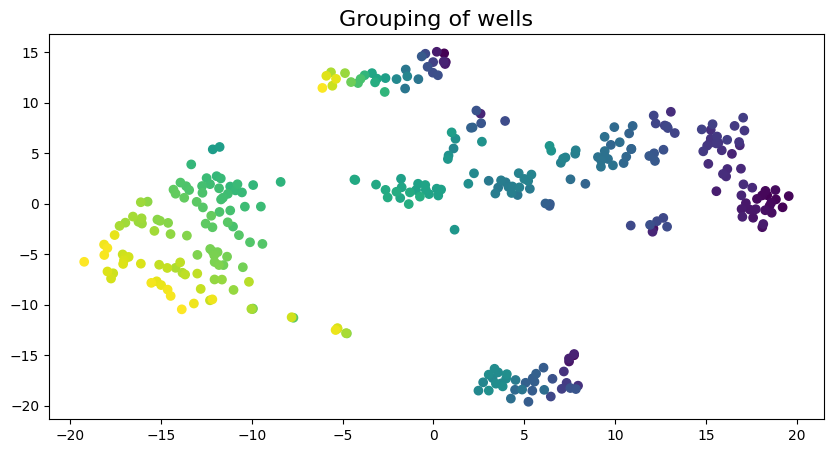

In [33]:
model = TSNE(n_components=2, learning_rate='auto',                  ) 

transformed = model.fit_transform(df_cl)

x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.figure(figsize=(10, 5))
plt.title('Grouping of wells',fontsize=16)
plt.scatter(x_axis, y_axis,c=df_cl.wellname_code ) #c=df_cluster.dropna().target 
plt.show()

In [34]:
from sklearn.cluster import KMeans

# ks = range(1, 10)
# inertias = []
 
# for k in ks:
#     model = KMeans(n_clusters=k)
#     model.fit(df_cl)
#     inertias.append(model.inertia_)
     
# plt.plot(ks, inertias, '-o')
# plt.xlabel('number of clusters, k')
# plt.ylabel('inertia')
# plt.xticks(ks)
# plt.show()

In [35]:
model_cluster = KMeans(n_clusters=6) #5
df_cluster['labels'] = model_cluster.fit_predict(df_cl)


In [36]:
df_new['group_wells'] = 0

dict_group = {}
for well, label in zip(df_cluster['wellname_code'].values, df_cluster['labels'].values):
    dict_group[well] = label

df_new['group_wells'] = df_new['wellname_code'].apply(lambda x: dict_group.get(x, 'Unknown'))


In [37]:
columns = ['dept', 'target', 'wellname', 'group_wells','gr', 'den', 'dt', 'cal', 'resd',
       'wellname_code', 'Horizon_1', 'Horizon_2', 'LSS_2_T', 'RO____T',
       'USS_1_T', 'USS_2_T', 'USS_3.1_T', 'ZEZ2A_T', ]
df_new =df_new[columns]

So, we have grouped our wells into groups. According to our research, all wells can be divided into 5 or 6 categories. We have received one additional feature and will continue to analyze its impact on the dataset.

In [38]:
labl = LabelEncoder()

df_new['type_wellname'] = labl.fit_transform(df_new.wellname.apply(lambda x:x.split('-')[0]))
df_new = df_new[['dept', 'target', 'wellname','type_wellname', 'group_wells', 'gr', 'den', 'dt', 'cal',
       'resd', 'wellname_code', 'Horizon_1', 'Horizon_2', 'LSS_2_T', 'RO____T',
       'USS_1_T', 'USS_2_T', 'USS_3.1_T', 'ZEZ2A_T']]


Let's assume that wells with similar names probably have a similar type, structure, or other characteristics. This new feature may be useful in the future.


 
To clean up the data from emissions, it is proposed to analyze each well separately. Given that the dataset contains information from different areas with different types of soils and rocks, and therefore different information from sensors, this approach seems reasonable.

In [39]:
names = df.wellname.unique()

In [40]:
def clean_df(df, col_name):
    names = df['wellname'].unique()#.values
    
    clean_data = []
    
    for name in names:
        temp = df[df['wellname'] == name][col_name]
        
        q1, q3 = np.percentile(temp, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        
        clean_data.append(df[df.index.isin(temp[(temp <= upper_bound) & (temp >= lower_bound)].index)])
    
    clean_df = pd.concat(clean_data, ignore_index=True)
    
    return clean_df

# df_clean = clean_df(df_new,'den')
# df_clean = clean_df(df_clean,'gr')


In [41]:

# with open('df.pickle', 'wb') as f:
#     pickle.dump(df_clean, f)

In [42]:
with open('/kaggle/input/df-clean-11/df (1).pickle', 'rb') as f:
    df_clean = pickle.load(f)

    
print('Количество выбросов = ',len(df_new)-len(df_clean))   

Количество выбросов =  14165


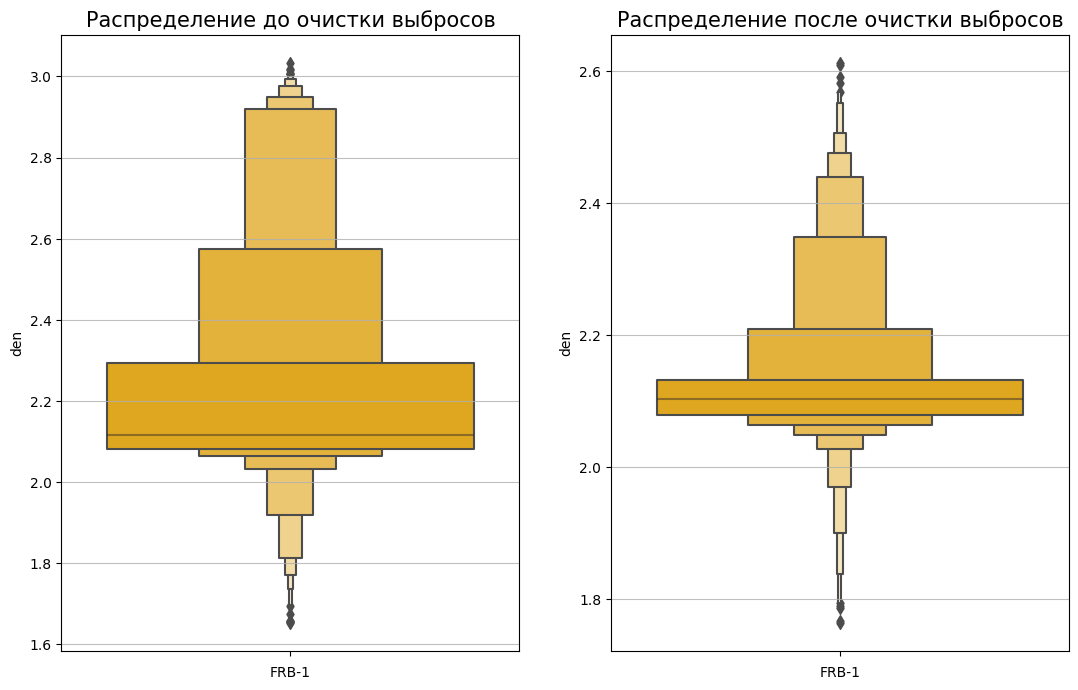

In [43]:
plt.figure(figsize=(13,8))

plt.subplot(1, 2, 1)
plt.grid(alpha=0.8)

sns.boxenplot(y = df_new[df_new.wellname==names[69]]['den'],color = "#ffb400", ) ;
plt.xlabel(names[69])
plt.title("Распределение до очистки выбросов", fontsize=15)


plt.subplot(1, 2, 2)
plt.grid(alpha=0.8)

sns.boxenplot(y = df_clean[df_clean.wellname==names[69]]['den'], color = "#ffb400", ) ;

plt.xlabel(names[69])
plt.title("Распределение после очистки выбросов", fontsize=15)
plt.show()


After carefully working with the missing values, I developed two strategies:

1. Split the data into two datasets, each of which will have a different number of columns. In the first dataset, there will be wells where the columns "dt" and "red" consist entirely of NaN. For these wells, we will remove these columns and then create a model to determine the target variables. All speakers will be included in the second set. For the columns "dt" and "resd" in this dataset, we will try to train a model that will replace these gaps for us.

2. Try to train a model that will predict the values of the missing data "dt" and "resd" based on the remaining available features.

In [44]:
labl = LabelEncoder()
df_clean['target'] = labl.fit_transform(df_clean.target.values)

In [45]:
all_na = pd.DataFrame(df_clean.query('dt.isna()').wellname.value_counts().reset_index())
all_na['total_count'] = all_na['wellname'].apply(lambda x : len(df_clean[df_clean.wellname==x]))
all_na ['norm_count'] = all_na['count']/all_na['total_count']

wellname_na = all_na[all_na.norm_count>=0.61].wellname.tolist()
wellname_na.extend(['ZND-11','PAU-6', 'SAP-10', 'EKR-208', 'AMR-12A'])
wellname_na.extend(['SAP-8', 'BIR-2A', 'ZVN-2', 'ZND-12B', 'KPD-4', 'TJM-2B', 'EKL-12', 'KPD-12'])
df_na = df_clean[df_clean.wellname.isin(wellname_na)]

df_clean = df_clean[~df_clean.wellname.isin(wellname_na)]

# df_clean.drop(['target','wellname'],axis = 1,inplace = True)
# df_na.drop(['target','wellname','resd','dt'],axis = 1,inplace = True)


# df_clean.drop(['wellname'],axis = 1,inplace = True)
df_na.drop(['resd','dt'],axis = 1,inplace = True) #'wellname',

In [46]:
df_knn_inp = df_clean[df_clean.wellname.isin(['BIR-13B','TUS-4','BIR-6'])]
df_clean = df_clean[~df_clean.wellname.isin(['BIR-13B','TUS-4','BIR-6'])]

imputer = KNNImputer()

df_knn_inp.drop('wellname',inplace = True, axis =1)
knn_inp = pd.DataFrame(imputer.fit_transform(df_knn_inp))
knn_inp.columns = df_knn_inp.columns

In [47]:
df_na.isna().sum()

dept             0
target           0
wellname         0
type_wellname    0
group_wells      0
gr               0
den              0
cal              0
wellname_code    0
Horizon_1        0
Horizon_2        0
LSS_2_T          0
RO____T          0
USS_1_T          0
USS_2_T          0
USS_3.1_T        0
ZEZ2A_T          0
dtype: int64

Попробуем заполнить пропуски в колонках

In [48]:
col = ['dept', 'gr', 'den', 'dt','group_wells','wellname_code','type_wellname' ]#'resd'
train = df_clean.dropna()
target = train['cal']

X_train, X_test, y_train, y_test = train_test_split(train[col], target, test_size=0.33, random_state=12,shuffle= True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=12,shuffle= True)


In [49]:
rfc =  RandomForestRegressor()
rfc.fit(X_train, y_train)

print('rmse_test = ',MSE(y_test,rfc.predict(X_test),squared = False))
print('mse_test = ',MSE(y_test,rfc.predict(X_test),squared = True))

print('')

print('rmse_val = ',MSE(y_val,rfc.predict(X_val),squared = False))
print('mse_val = ',MSE(y_val,rfc.predict(X_val),squared = True))

rmse_test =  0.3731770717185458
mse_test =  0.13926112685642866

rmse_val =  0.3994980167594915
mse_val =  0.15959866539476691


In [50]:
pred = df_clean[df_clean.cal.isna()]
pred['cal'] = rfc.predict(pred[col])
df_clean = pd.concat([df_clean,pred]).dropna(subset='cal').sort_index()#.isna().sum()

In [51]:
imputer = KNNImputer()

temp = pd.DataFrame(imputer.fit_transform(df_clean[df_clean.columns[5:10]]))
temp.columns = df_clean.columns[5:10]
df_clean['dt'] = temp['dt'].values
df_clean['resd'] = temp['resd'].values


In [52]:
df_clean.isna().sum()

dept             0
target           0
wellname         0
type_wellname    0
group_wells      0
gr               0
den              0
dt               0
cal              0
resd             0
wellname_code    0
Horizon_1        0
Horizon_2        0
LSS_2_T          0
RO____T          0
USS_1_T          0
USS_2_T          0
USS_3.1_T        0
ZEZ2A_T          0
dtype: int64

I want to share some observations about the work done. Despite the fact that visually the work done may not look like significant progress, a lot of effort has been spent on cleaning up the data and trying to fill in the gaps. Various approaches have been taken, including the use of TabNetRegressor to fill in gaps in the data, as well as the use of blending simple models and automated machine learning from autoglio. However, the best result I managed to achieve was an RMSE of about 2. While this value seems acceptable, given the scale of values from 0 to 430 for the variable "dt", but without understanding the specifics of the measurements, what accuracy the measuring probe has and how our obtained values may affect the final target estimate. Therefore, I decided to divide the data into two sets and continue working with each of them using my own model. If desired and sufficiently immersed in the data, you can further develop these strategies and try to predict the missing values. We currently have three skip-free datasets, and we can finally move on to developing new features.

In [53]:
df_clean.insert(loc= 6 , column='gr_cal_multi', value=df_clean['gr'] * df_clean['cal'])
df_clean.insert(loc= 7 , column='gr_change', value=df_clean['gr'].diff())
df_clean.insert(loc= 8 , column='gr_gradient', value=np.gradient(df_clean['gr']))

df_clean.insert(loc= 10 , column='den_cal_multi', value=df_clean['den'] * df_clean['cal'])
df_clean.insert(loc= 11 , column='den_change', value=df_clean['den'].diff())
df_clean.insert(loc= 12 , column='den_gradient', value=np.gradient(df_clean['den']))

df_clean.insert(loc= 14 , column='dt_cal_multi', value=df_clean['dt'] * df_clean['cal'])
df_clean.insert(loc= 15 , column='dt_change', value=df_clean['dt'].diff())
df_clean.insert(loc= 16 , column='dt_gradient', value=np.gradient(df_clean['dt']))

df_clean.insert(loc= 19 , column='log_resd', value=np.log1p(df_clean['resd']))


In [54]:
df_clean.insert(loc= 20 , column='log_resd_cal_multi', value=df_clean['log_resd'] * df_clean['cal'])
df_clean.insert(loc= 21 , column='log_resd_change', value=df_clean['log_resd'].diff())
df_clean.insert(loc= 22 , column='log_resd_gradient', value=np.gradient(df_clean['log_resd']))

cond = df_clean.target.fillna('0').map(lambda x: 1 if x!=8 else 0).astype('int')
df_clean.insert(loc= 2 , column='target_bin', value=cond)

df_clean = df_clean.drop('wellname', axis =1)


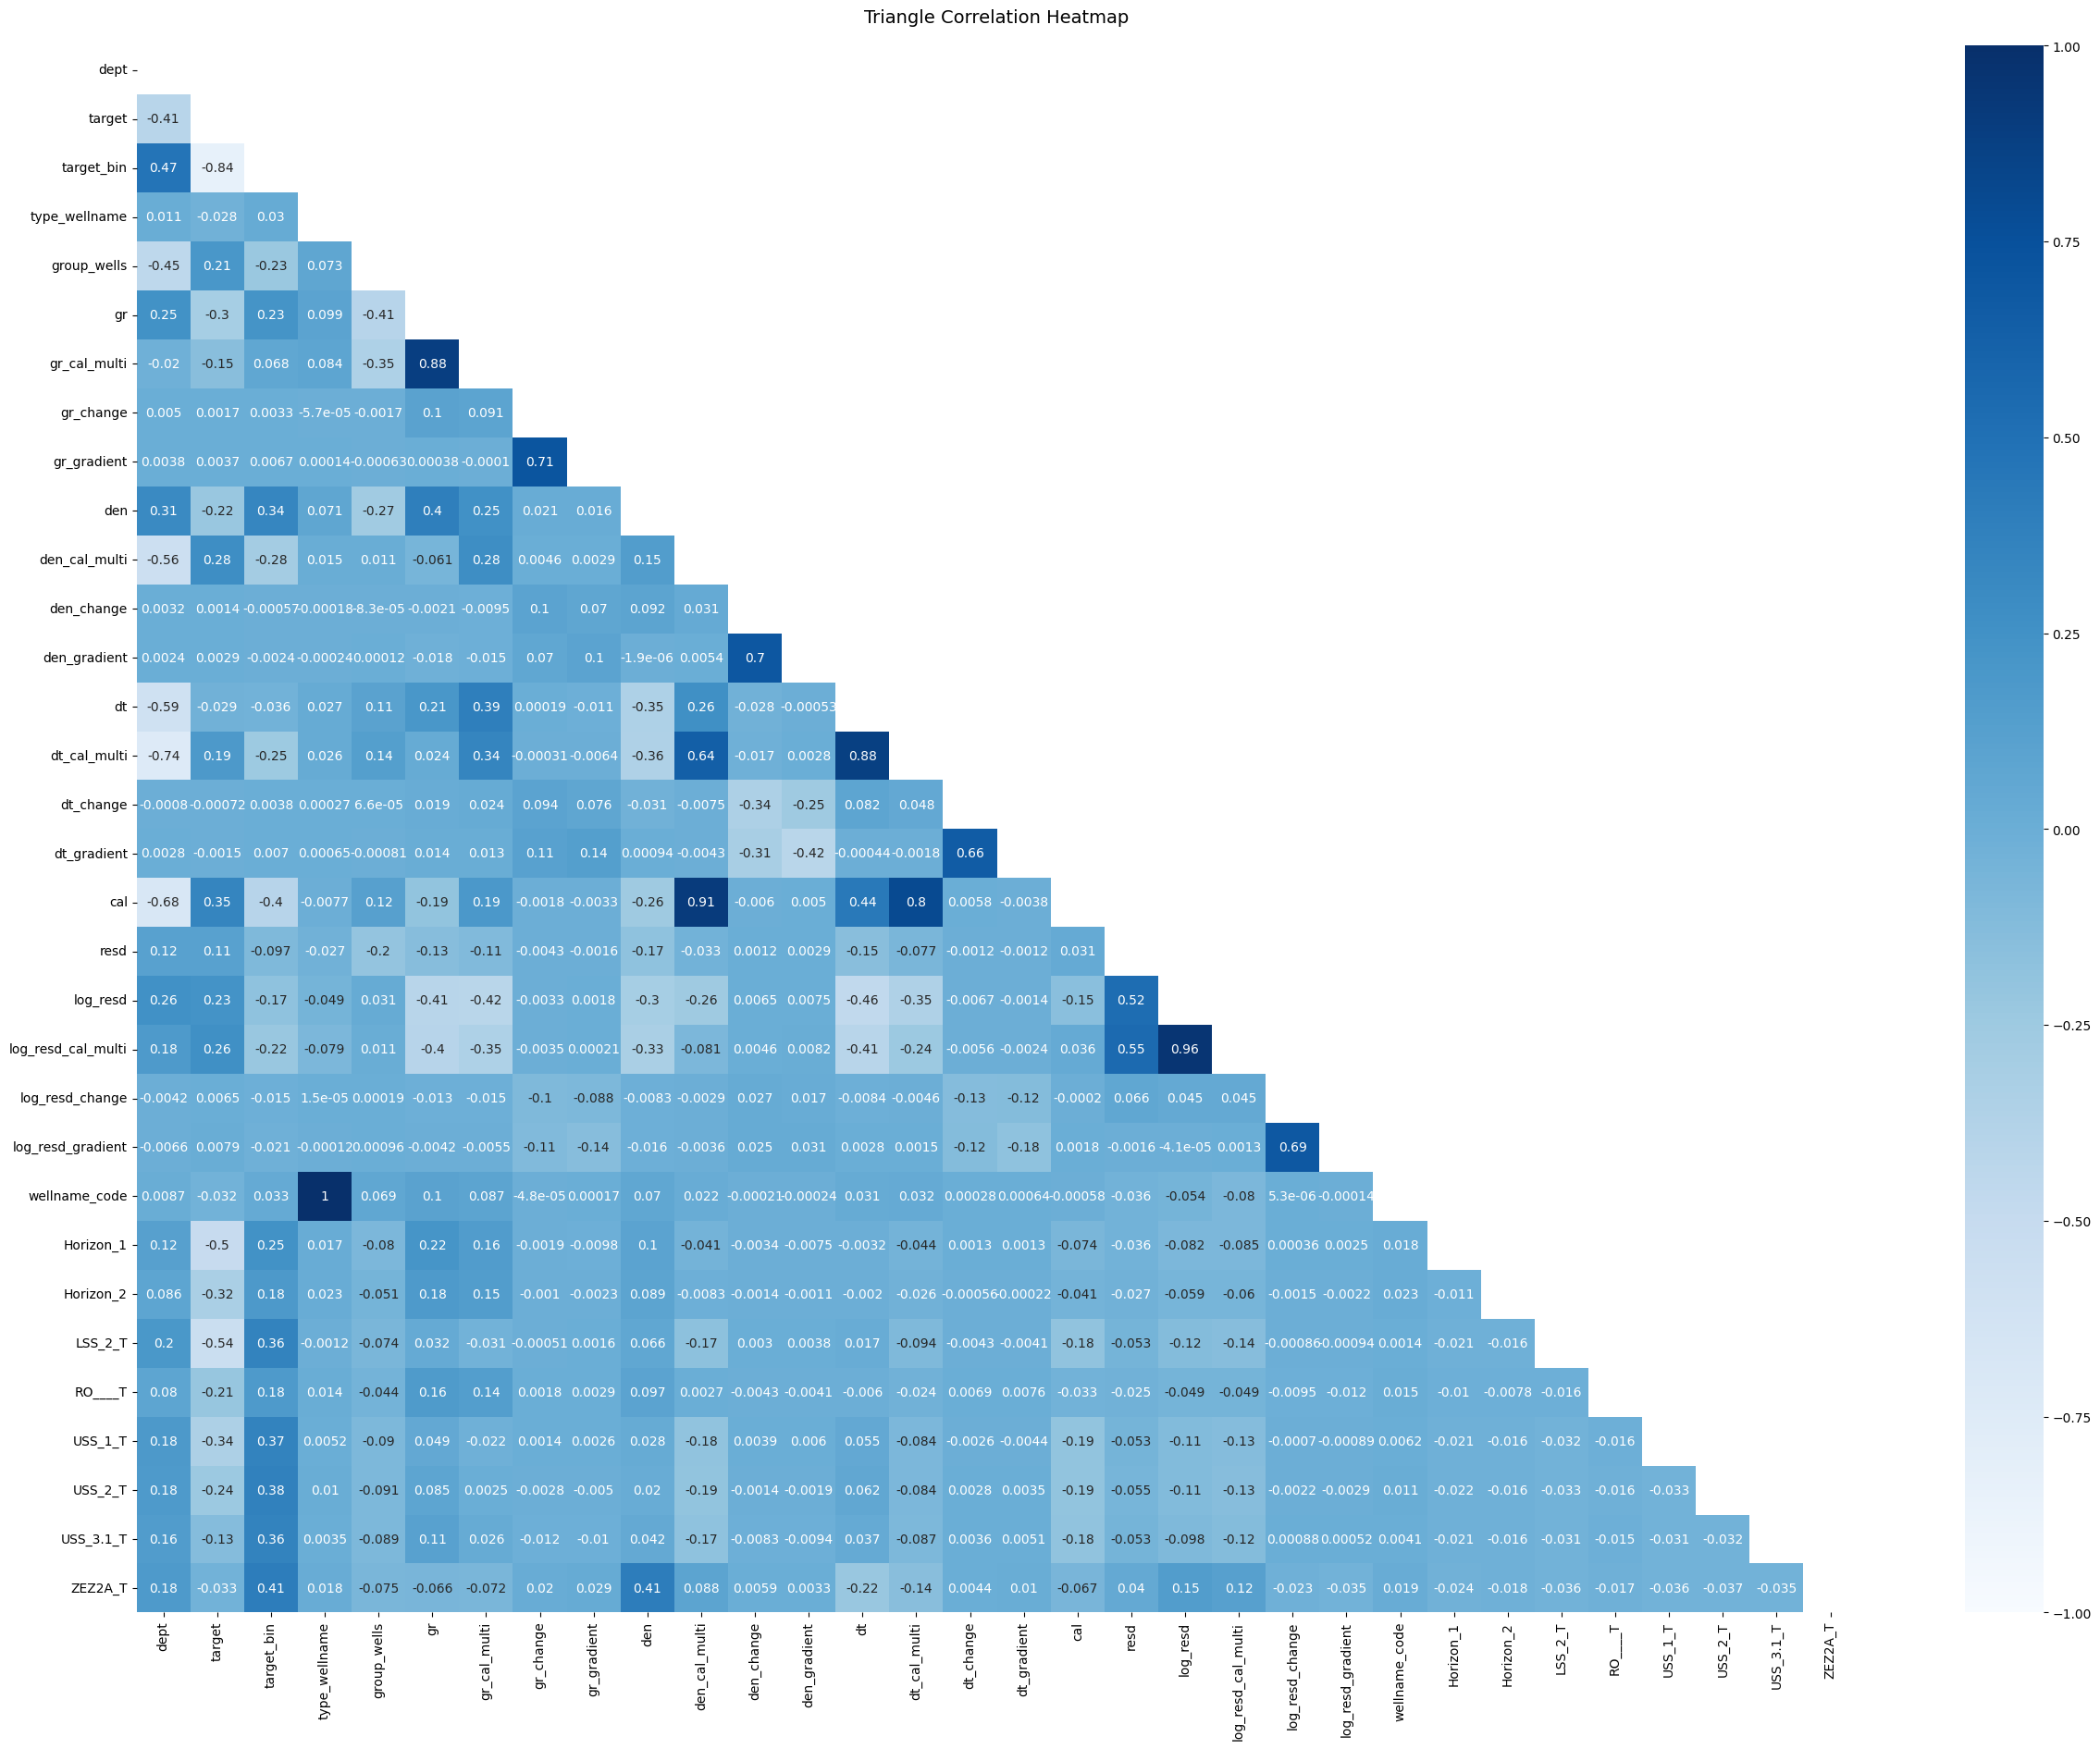

In [55]:
plt.figure(figsize=(30, 22))
mask = np.triu(np.ones_like(df_clean.corr() ))
heatmap = sns.heatmap(df_clean.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':14}, pad=18);


We analyzed the correlation between our columns and noticed that the target variables correlate well with the sensor data and with the tower grouping column. It is proposed to divide the columns into two datasets: one for the target variables and one for the features that will be used for forecasting. We have three types of target variables, it is proposed to start with a binary classification to determine at what depth any useful layer is located for us. Then we can consider the possibility of dividing the mine sections into different layers. In the future, it is worth trying a multi-class classification for all layers at once.

### **Моделирование**

In [56]:
target_column = [ 'target', 'target_bin', 'Horizon_1',
       'Horizon_2', 'LSS_2_T', 'RO____T', 'USS_1_T', 'USS_2_T', 'USS_3.1_T',
       'ZEZ2A_T']
df_clean =df_clean.dropna()

# val = random.sample(df_clean.wellname_code.unique().tolist(), 3, ) 

val = pd.Series(df_clean['wellname_code'].unique()).sample(7, random_state=1).tolist()

valid_wells = df_clean[df_clean.wellname_code.isin(val)].reset_index(drop= True)
train = df_clean[~df_clean.wellname_code.isin(val)].reset_index(drop= True)

target = train[target_column]
train = train[train.columns[~train.columns.isin(target.columns)]]

In [57]:
gr = train['type_wellname']

df = train
df['target_bin'] = target['target_bin']

df = df.reset_index(drop=True)


df_val = valid_wells.drop([ 'target',  'Horizon_1',
       'Horizon_2', 'LSS_2_T', 'RO____T', 'USS_1_T', 'USS_2_T', 'USS_3.1_T',
       'ZEZ2A_T'],axis =1 )

By using the borutashap library, I got a set of functions that are important in our calculations. I will not perform these calculations, but simply run the code and the result of its execution. The graph will show a list of the importance of our features and below the list itself. After experimenting with the binary target and dataset, I got an almost perfect Roc AUC, which indicates a leak of our values. We can see this from the corelation graph, I got such a big 'score', I went to study this problem. So the library from H2O agreed with my conclusions and gave me the following recommendations:
- Data leakage detected
- Possible leakage detected in training data for feature dept (AUC: 0.9263241 )
- Possible leakage detected in training data for feature cal (AUC: 0.8896257 )
- Possible leakage detected in training data for feature den (AUC: 0.8793946 )
- Possible leakage detected in training data for feature dt (AUC: 0.8757774 )
- Consider dropping leaky features.

And the question arises: What should we do? if this is all our data that we were given in the original frame. You can split a column with a depth into a categorical feature with different reference points (less than 1000m, from 1000 to 1500m, etc.), perhaps this will reduce leakage, but it will not defeat it and will not greatly affect the result, since I tried to completely remove some of the columns from the recommendation list and my speed did not drop much. Therefore, I suggest leaving everything as I intended from the beginning, that we can determine with a good probability whether this layer is important to us or not. This will be our additional feature, perhaps it will help us further in multiclass classification. I also allocated from 2 to 6 wells to test the final models on this data (which she did not see) and I tried two types of separation into a test and training set (StratifiedKFold and GroupKFold). The first one proved to be better, so I left it in my calculations. It was possible, of course, to play around with a configurable threshold and improve our binary classification, I tried it in GroupKFold and improved the final results, but it all needed to take more time and I interrupted experiments in this area. And as I wrote above, I stayed with StratifiedKFold.

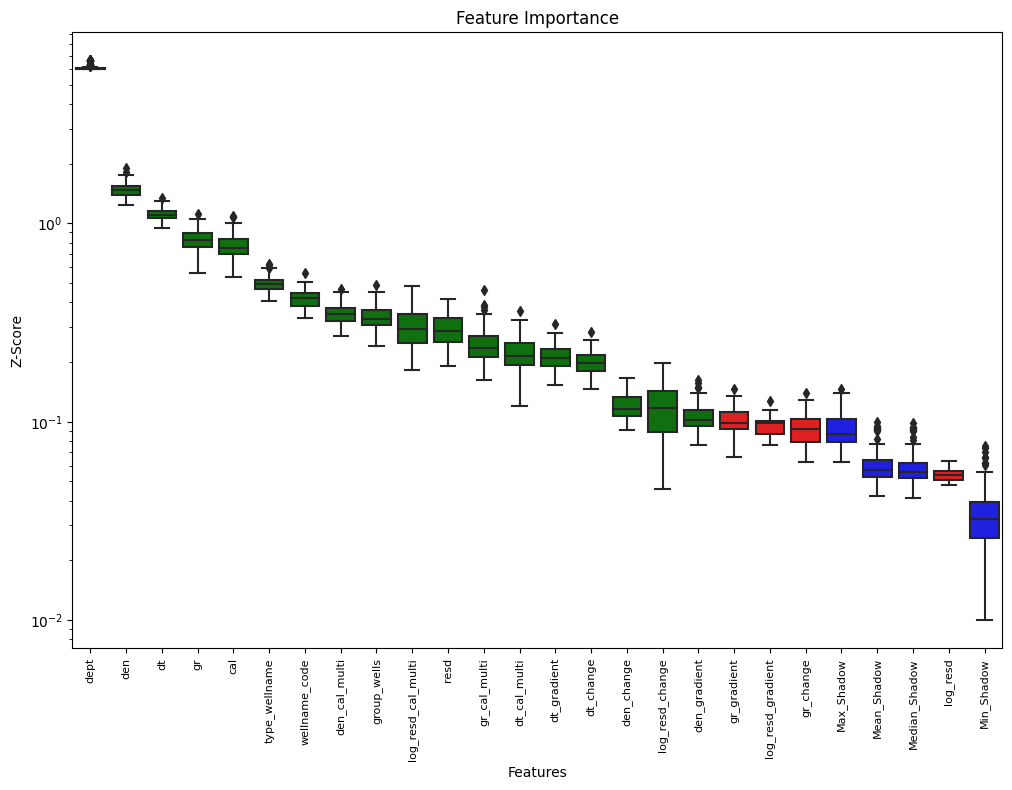

In [58]:
from PIL import Image, ImageDraw
col = ['group_wells', 'dt', 'dt_cal_multi', 'resd', 'dt_change', 'den_gradient', 'gr', 
       'type_wellname', 'den_change', 'dept', 'wellname_code', 'log_resd_change', 'gr_cal_multi', 
       'log_resd_cal_multi', 'den', 'cal', 'dt_gradient', 'den_cal_multi']

Image.open('/kaggle/input/pictures/__results___82_2.png') 


In [59]:
# !pip install borutashap
# from BorutaShap import BorutaShap
# from xgboost import XGBClassifier

# model = XGBClassifier()

# Feature_Selector = BorutaShap(model=model,
#                               importance_measure='shap',
#                               classification=True)
# target_col = 'target_bin'
# X = df.drop(['fold',target_col],axis =1)
# y = df[target_col]
 
# Feature_Selector.fit(X=X, y=y, n_trials=100, sample=False, train_or_test = 'test', normalize=True,verbose=True)
# subset = Feature_Selector.Subset()
# Feature_Selector.plot(which_features='all')


18 attributes confirmed important: **['group_wells', 'dt', 'dt_cal_multi', 'resd', 'dt_change', 'den_gradient', 'gr', 'type_wellname', 'den_change', 'dept', 'wellname_code', 'log_resd_change', 'gr_cal_multi', 'log_resd_cal_multi', 'den', 'cal', 'dt_gradient', 'den_cal_multi']**

4 attributes confirmed unimportant: **['log_resd', 'gr_change', 'gr_gradient', 'log_resd_gradient']**

0 tentative attributes remains: []

In [60]:
num_folds = 3
verbose = 500
seed = 4242
n_est = 1500 

# drop_col = ['target_bin','dept', 'log_resd', 'gr_change', 'gr_gradient', 'log_resd_gradient','cal' ,'den', 'dt']

drop_col = ['target_bin','log_resd', 'gr_change', 'gr_gradient', 'log_resd_gradient',]#'dept',]

X = df.drop(drop_col,axis =1 )

y = df['target_bin']



In [61]:
# import optuna
# from optuna.samplers import TPESampler
# X = df.drop(['target_bin',],axis =1)
# y = df['target_bin']


# def objective(trial):
        
#     folds = StratifiedKFold(
#         n_splits     = 5,
#         random_state = 42,
#         shuffle      = True
#     )

#     param = {
#         "iterations"         : 1000,
#         "used_ram_limit"     : "25gb",
#         "eval_metric"        : 'AUC',
#         "objective"          : 'Logloss',

#         "depth"              : trial.suggest_int("depth", 1, 15),
#         "min_data_in_leaf"   : trial.suggest_int("min_data_in_leaf", 1, 100),
#         "colsample_bylevel"  : trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         "learning_rate"      : trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),        
#         "l2_leaf_reg"        : trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         "random_strength"    : trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
#         "od_wait"            : trial.suggest_int("od_wait", 10, 50),

#     }


    
#     auc_vals = []
#     for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
#         X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#         X_val, y_val     = X.iloc[valid_idx], y.iloc[valid_idx]
        

#         train_pool = Pool(X_train, 
#                           y_train, 
#                           )

#         val_pool   = Pool(X_val, 
#                           y_val,
#                           )
    
#         clf = CatBoostClassifier(**param)
#         clf.fit(train_pool, 
#                 eval_set              = val_pool,
#                 verbose               = 50,
#                 early_stopping_rounds = 100
#         )

    
#         y_pred_val = clf.predict_proba(X_val)[:,1]
#         auc_val    = roc_auc_score(y_val, y_pred_val)
#         auc_vals.append(auc_val)
#         print(f"Confusion matrix :\n {confusion_matrix( clf.predict(X_val),y_val)}")

#     return np.mean(auc_vals)




# if __name__ == "__main__":


#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective, n_trials=20)

#     print("Number of finished trials: {}".format(len(study.trials)))
#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))
#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [62]:
bestParams = {'depth': 8, 'min_data_in_leaf': 95, 
              'colsample_bylevel': 0.9906744781259593,
              'learning_rate': 0.015374987410408108,
              'l2_leaf_reg': 0.21454386836792207,
              'random_strength': 0.00037529112479686667, 
              'od_wait': 25}

bestParams = {
    **{'eval_metric' : 'AUC', 'iterations' : n_est},
    **bestParams
}

In [63]:
# folds = StratifiedGroupKFold(n_splits=num_folds)
    
# auc_vals = []
# f1_vals = []
# for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y,groups=gr)):
    
#     X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#     X_val, y_val     = X.iloc[valid_idx], y.iloc[valid_idx]
    
#     train_pool = Pool(X_train, y_train, )
    
#     val_pool   = Pool(X_val, y_val,)
    
#     clf = CatBoostClassifier(**bestParams)
    
#     clf.fit(train_pool, eval_set = val_pool, verbose  = 500)
    
#     y_pred_val = clf.predict_proba(X_val)[:,1]
    
#     auc_val    = roc_auc_score(y_val, y_pred_val)
    
#     f1_val = f1_score(y_val, clf.predict(X_val), average='macro')

#     print("AUC for fold ",n_fold,": ",auc_val)
#     print(f"f1 score  {f1_val}")

#     auc_vals.append(auc_val)
#     f1_vals.append(f1_val)

#     print(f"Confusion matrix :\n {confusion_matrix(y_val, clf.predict(X_val),)}")
#     print(f"Confusion matrix :\n {confusion_matrix(y_val,clf.predict_proba(X_val)[:,1] >= 0.47)}")

#     print("----------------")


In [64]:
folds = StratifiedKFold(
    n_splits     = num_folds,
    random_state = seed,
    shuffle      = True)

auc_vals = []
f1_vals = []
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val     = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train, )
    
    val_pool   = Pool(X_val, y_val,)
    
    clf = CatBoostClassifier(**bestParams)
    
    clf.fit(train_pool, eval_set = val_pool, verbose  = 500)
    
    y_pred_val = clf.predict_proba(X_val)[:,1]
    auc_val    = roc_auc_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, clf.predict(X_val), average='macro')
    
    
    print("AUC for fold ",n_fold,": ",auc_val)
    print(f"f1 score  {f1_val}")

    auc_vals.append(auc_val)
    f1_vals.append(f1_val)

    print(f"Confusion matrix :\n {confusion_matrix(y_val, clf.predict(X_val),)}")
    print("----------------")

    print(f"Confusion matrix with threshold :\n {confusion_matrix(y_val,clf.predict_proba(X_val)[:,1] >= 0.47)}")

    print("----------------")


0:	test: 0.9896975	best: 0.9896975 (0)	total: 82.7ms	remaining: 2m 4s
500:	test: 0.9998006	best: 0.9998006 (498)	total: 12.5s	remaining: 24.9s
1000:	test: 0.9998797	best: 0.9998797 (1000)	total: 25.1s	remaining: 12.5s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.9998883175
bestIteration = 1116

Shrink model to first 1117 iterations.
AUC for fold  0 :  0.99988831747583
f1 score  0.9943905424335613
Confusion matrix :
 [[35110   103]
 [   44  7977]]
----------------
Confusion matrix with threshold :
 [[35103   110]
 [   38  7983]]
----------------
0:	test: 0.9882768	best: 0.9882768 (0)	total: 30ms	remaining: 44.9s
500:	test: 0.9998661	best: 0.9998661 (500)	total: 12.4s	remaining: 24.8s
1000:	test: 0.9999285	best: 0.9999285 (1000)	total: 25.1s	remaining: 12.5s
1499:	test: 0.9999474	best: 0.9999474 (1499)	total: 37.5s	remaining: 0us

bestTest = 0.999947372
bestIteration = 1499

AUC for fold  1 :  0.9999473720459143
f1 score  0.9959506008396599
Confusion matrix :
 [[35

In [65]:
print("Mean AUC: ",np.mean(auc_vals))
print("Mean F1: ",np.mean(f1_vals))

Mean AUC:  0.9999146977906129
Mean F1:  0.9951103883186027


In [66]:
def conf_matrix(X,y, normalize= None,title = None):
    class_names = ['0','1']
    disp = ConfusionMatrixDisplay.from_estimator(
            clf,
            X,
            y,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize)
    plt.title(title, fontsize=10)

    
    plt.show()

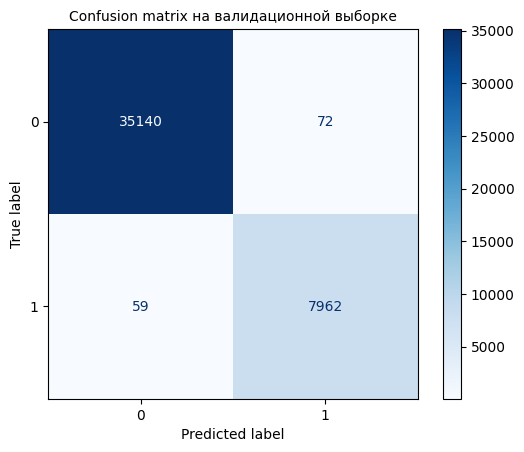

In [67]:
conf_matrix(X_val,y_val, None,'Confusion matrix на валидационной выборке')


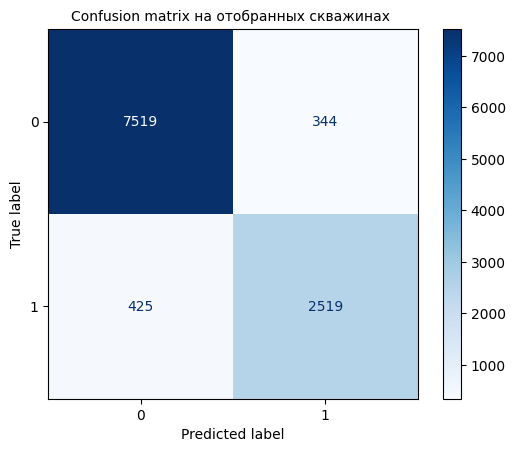

In [68]:
conf_matrix(df_val.drop(drop_col,axis =1 ),
        df_val['target_bin'], None,'Confusion matrix на отобранных скважинах ')


It can be seen that we got a very good result, even on five selected wells, which our model did not see during the training process.This means that based on the data from our sensors, we can predict with good accuracy at what depth the layers important for our research or mining will be.
The next step is to complicate the task and try a multiclass classification in this dataset.

In [69]:
df['target_bin_pred'] = clf.predict(df.drop(drop_col,axis =1 ))

In [70]:
df_val['target_bin_pred'] = clf.predict(df_val.drop(drop_col,axis =1 ))


In [71]:
df['target'] = target['target']
df_val['target'] = valid_wells['target']

In [72]:

# drop_col = ['target_bin','dept', 'log_resd', 'gr_change', 'gr_gradient', 'log_resd_gradient','cal' ,'den', 'dt']

drop_col = ['target_bin','target']#,'dept',

X = df.drop(drop_col,axis =1 )

y = df['target']

In [73]:
f1_vals = []
mult_clf = CatBoostClassifier(
                          n_estimators=2000, 
                          verbose=500,
                          bootstrap_type="Bernoulli",
                          loss_function='MultiClass',
                          )

folds = GroupKFold(n_splits=num_folds)
gr = df.type_wellname 

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y,groups=gr)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val     = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train, )
    
    val_pool   = Pool(X_val, y_val,)
    
    
    mult_clf.fit(train_pool, eval_set = val_pool)
    
    
    f1_val = f1_score(y_val, mult_clf.predict(X_val), average=None)
    
    print("f1 for fold ",n_fold,": \n",f1_val)

    f1_vals.append(f1_val)
    print("----------------")

    print(f"Confusion matrix :\n {confusion_matrix(y_val, mult_clf.predict(X_val))}")
    print("----------------")
    print(classification_report(y_val,mult_clf.predict(X_val)))
    print("----------------")

Learning rate set to 0.090584
0:	learn: 1.5979984	test: 1.6229907	best: 1.6229907 (0)	total: 99.7ms	remaining: 3m 19s
500:	learn: 0.0474205	test: 0.3100906	best: 0.2530885 (66)	total: 36.6s	remaining: 1m 49s
1000:	learn: 0.0258769	test: 0.3471521	best: 0.2530885 (66)	total: 1m 13s	remaining: 1m 12s
1500:	learn: 0.0165417	test: 0.3752305	best: 0.2530885 (66)	total: 1m 49s	remaining: 36.6s
1999:	learn: 0.0114357	test: 0.3959518	best: 0.2530885 (66)	total: 2m 26s	remaining: 0us

bestTest = 0.2530884549
bestIteration = 66

Shrink model to first 67 iterations.
f1 for fold  0 : 
 [0.49009247 0.20876827 0.50102249 0.46406053 0.39591141 0.29272031
 0.38095238 0.97701827 0.9993717 ]
----------------
Confusion matrix :
 [[  371    36    65   139     0     7    27     1     4]
 [  153    50     3   125     1     1    15     1     0]
 [   35     0   980     9   359    38   144    27     7]
 [   76    31     6   184     0     0     3    13     0]
 [   21     0   530     3   581   150   211     7   

In [74]:
print("Mean F1 per class:\n",pd.DataFrame(f1_vals).mean(axis = 0))

Mean F1 per class:
 0    0.508610
1    0.187928
2    0.523366
3    0.438876
4    0.331648
5    0.343164
6    0.489314
7    0.969417
8    0.999355
dtype: float64


In [75]:
print(confusion_matrix(df_val.target, mult_clf.predict(df_val.drop([ 'target',  'target_bin'],axis =1))))
print("------------------------------------------------")
print(f1_score(df_val.target, mult_clf.predict(df_val.drop([ 'target',  'target_bin'],axis =1)), average=None))



[[ 159    6    2   37    1    3   37    0   55]
 [  90    8    0   19    0    0    9    0   20]
 [  10    0  254    0   15    1    7    0  180]
 [  37   13    0   63    0    0    1    1   17]
 [  10    0  113    0  145   43   12    0  101]
 [   4    0  108    0   88  171   56    0   19]
 [  24    0   86    0   35   51  191    0   10]
 [   4    1    0    2    0    0    0  602   23]
 [  86    2   62    3    9    1   13  168 7519]]
------------------------------------------------
[0.43922652 0.09090909 0.46520147 0.4921875  0.40446304 0.47765363
 0.52835408 0.85816108 0.95135067]


In [76]:
f1_vals_2 = []
mult_clf_2 = CatBoostClassifier(
                          n_estimators=2000, 
                          verbose=500,
                          bootstrap_type="Bernoulli",
                         loss_function='MultiClass',
                          )

folds_2 = StratifiedKFold(
    n_splits     = num_folds,
    random_state = seed,
    shuffle      = True)

for n_fold, (train_idx, valid_idx) in enumerate(folds_2.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val     = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train, )
    
    val_pool   = Pool(X_val, y_val,)
    
    
    mult_clf_2.fit(train_pool, eval_set = val_pool)
    
    
    f1_val = f1_score(y_val, mult_clf_2.predict(X_val), average=None)
    
    print("f1 for fold ",n_fold,": \n",f1_val)

    f1_vals_2.append(f1_val)
    print("----------------")

    print(f"Confusion matrix :\n {confusion_matrix(y_val, mult_clf_2.predict(X_val))}")
    print("----------------")
    print(classification_report(y_val,mult_clf_2.predict(X_val)))
    print("----------------")

Learning rate set to 0.090588
0:	learn: 1.6148678	test: 1.6145711	best: 1.6145711 (0)	total: 60.9ms	remaining: 2m 1s
500:	learn: 0.0681469	test: 0.0909035	best: 0.0909035 (500)	total: 37.5s	remaining: 1m 52s
1000:	learn: 0.0384623	test: 0.0702782	best: 0.0702782 (1000)	total: 1m 14s	remaining: 1m 14s
1500:	learn: 0.0253495	test: 0.0625259	best: 0.0625251 (1498)	total: 1m 52s	remaining: 37.4s
1999:	learn: 0.0180589	test: 0.0588680	best: 0.0588602 (1998)	total: 2m 30s	remaining: 0us

bestTest = 0.05886015071
bestIteration = 1998

Shrink model to first 1999 iterations.
f1 for fold  0 : 
 [0.84320557 0.71537291 0.9193231  0.81652893 0.87072243 0.87435709
 0.90148554 0.99462536 0.9996593 ]
----------------
Confusion matrix :
 [[  484    38     4     5     1     1    34     0     1]
 [   40   235     0    39     0     2    10     1     0]
 [    4     0  1168     0    79     9     5     0    17]
 [    5    49     1   247     0     0     5     2     0]
 [    0     0    68     0  1145    85    

In [77]:
print("Mean F1 per class:\n",pd.DataFrame(f1_vals_2).mean(axis = 0))

Mean F1 per class:
 0    0.841698
1    0.697953
2    0.913943
3    0.813142
4    0.874303
5    0.884267
6    0.908661
7    0.993164
8    0.999342
dtype: float64


In [78]:
print(confusion_matrix(df_val.target, mult_clf_2.predict(df_val.drop([ 'target',  'target_bin'],axis =1))))
print("------------------------------------------------")
print(f1_score(df_val.target, mult_clf_2.predict(df_val.drop([ 'target',  'target_bin'],axis =1)), average=None))



[[ 170   13    6   24    5    0   27    0   55]
 [  43   39    1   41    0    0    2    0   20]
 [   7    0  236    0   24    2   18    0  180]
 [   0   37    0   77    0    0    0    1   17]
 [   7    0   88    1  168   52    7    0  101]
 [   3    0   74    0   41  222   87    0   19]
 [  18    0   94    0   32   35  208    0   10]
 [   0    1    1    3    0    0    0  604   23]
 [  47   33   62    5    7    0   26  164 7519]]
------------------------------------------------
[0.57142857 0.28996283 0.45869776 0.54416961 0.47931526 0.58652576
 0.5388601  0.86224126 0.95135067]


In [79]:
!pip install py-boost -q


In [80]:
import py_boost as pb
from py_boost import TLPredictor, TLCompiledPredictor,GradientBoosting
from py_boost.cv import CrossValidation

from py_boost import GradientBoosting

from py_boost.multioutput.sketching import *
from py_boost.multioutput.target_splitter import *
import cupy as cp


In [81]:
df_gr = df.reset_index(drop=True)
X_gr = df_gr.drop(['target_bin','target'],axis = 1)
y_gr = df_gr['target']
gr = df_gr['type_wellname']

In [83]:
# sketch = RandomProjectionSketch(1)
# sketch = RandomSamplingSketch(10)
# sketch = TopOutputsSketch(9)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_gr, y_gr,groups=gr)):

    
    X_train, y_train = X_gr.values[train_idx], y_gr.values[train_idx]
    X_val, y_val     = X_gr.values[valid_idx], y_gr.values[valid_idx]
    
    
    model = GradientBoosting(
        'crossentropy',
        ntrees=3000, lr=0.003, verbose=500, es=300, lambda_l2=.6,
                         min_data_in_leaf=10,
#         use_hess=False, 
                         max_bin=256, 
#                          multioutput_sketch=sketch,
        
)

    model.fit(X_train, y_train, eval_sets = [{'X': X_val, 'y': y_val}])
    
    print("n_fold = ", n_fold)

    pred = model.predict(X_val)
    print('-------------')

    d = pd.DataFrame(pred).T
    f = []
    for i in d.columns:
        f.append(d[i].argmax())
    pred = pd.DataFrame(f).values

    print(confusion_matrix(y_val,pred))

    print('-------------')
    
    print(classification_report(y_val,pred))
    
    print('-------------')
    

[05:36:36] Stdout logging level is INFO.
[05:36:36] GDBT train starts. Max iter 3000, early stopping rounds 300
[05:36:45] Iter 0; Sample 0, Crossentropy = 2.1770604377041143; 
[05:37:03] Iter 500; Sample 0, Crossentropy = 0.35262052905946745; 
[05:37:21] Iter 1000; Sample 0, Crossentropy = 0.25370125022742623; 
[05:37:39] Iter 1500; Sample 0, Crossentropy = 0.2507818584357874; 
[05:37:40] Early stopping at iter 1526, best iter 1226, best_score 0.24961026656500498
n_fold =  0
-------------
[[  339    92    40   142     4     7    22     0     4]
 [  115    86     3   128     0     2    15     0     0]
 [   49     1   975     8   376    78    92    13     7]
 [   72    59     6   170     0     0     4     2     0]
 [   26     0   533     4   622   172   139     7     0]
 [   79     4   375     1   423   395   345     2     0]
 [  171    12   264    16   113   461   466     0     0]
 [    1     4     4     8     0     0     1  1656     5]
 [    4     0    17     0     1     0     1     5

In [84]:
val_pred = model.predict(df_val.drop([ 'target',  'target_bin'],axis =1).values)
d = pd.DataFrame(val_pred).T
f = []
for i in d.columns:
    f.append(d[i].argmax())
val_pred = pd.DataFrame(f).values
print(confusion_matrix(df_val.target, val_pred))
print("------------------------------------------------")
print(f1_score(df_val.target, val_pred, average=None))



[[ 163   13    4   18    1    1   45    0   55]
 [  74   28    0   14    0    0   10    0   20]
 [  12    0  220    0   49    3    3    0  180]
 [  32   30    0   51    0    0    1    1   17]
 [  10    0  119    1  144   36   13    0  101]
 [   4    0   98    0  116  137   72    0   19]
 [  21    0   55    1   42  118  150    0   10]
 [   5    0    0    2    0    0    0  602   23]
 [  85    7   59    4    7    0    5  177 7519]]
------------------------------------------------
[0.46175637 0.25       0.43052838 0.4573991  0.36781609 0.36977058
 0.43103448 0.85269122 0.95135067]


In [85]:
for n_fold, (train_idx, valid_idx) in enumerate(folds_2.split(X_gr, y_gr)):

    
    X_train, y_train = X_gr.values[train_idx], y_gr.values[train_idx]
    X_val, y_val     = X_gr.values[valid_idx], y_gr.values[valid_idx]
    
    
    model_2 = GradientBoosting(
        'crossentropy',
        ntrees=3000, lr=0.003, verbose=500, es=300, lambda_l2=.6,
                         min_data_in_leaf=10,
#         use_hess=False, 
                         max_bin=256, 
#                          multioutput_sketch=sketch,
        
)

    model_2.fit(X_train, y_train, eval_sets = [{'X': X_val, 'y': y_val}])
    
    print("n_fold = ", n_fold)

    pred = model_2.predict(X_val)
    print('-------------')

    d = pd.DataFrame(pred).T
    f = []
    for i in d.columns:
        f.append(d[i].argmax())
    pred = pd.DataFrame(f).values

    print(confusion_matrix(y_val,pred))

    print('-------------')
    
    print(classification_report(y_val,pred))
    
    print('-------------')
    

[05:41:33] Stdout logging level is INFO.
[05:41:33] GDBT train starts. Max iter 3000, early stopping rounds 300
[05:41:33] Iter 0; Sample 0, Crossentropy = 2.176114418117084; 
[05:41:51] Iter 500; Sample 0, Crossentropy = 0.28309958909012045; 
[05:42:09] Iter 1000; Sample 0, Crossentropy = 0.17058464807934792; 
[05:42:27] Iter 1500; Sample 0, Crossentropy = 0.14554415904047088; 
[05:42:44] Iter 2000; Sample 0, Crossentropy = 0.12913683865838946; 
[05:43:01] Iter 2500; Sample 0, Crossentropy = 0.11730460656706784; 
[05:43:19] Iter 2999; Sample 0, Crossentropy = 0.10796314989621374; 
n_fold =  0
-------------
[[  465    38     2     9     0     4    49     0     1]
 [   78   190     0    40     0     3    15     1     0]
 [   17     0  1046     0   164    11    27     0    17]
 [   22    43     3   233     0     0     4     4     0]
 [    5     1   125     0   996   142    37     0     0]
 [   20     2    20     0   146  1004   177     0     0]
 [   48     4    33     1    37   120  1030

In [87]:
val_pred_2 = model_2.predict(df_val.drop([ 'target',  'target_bin'],axis =1).values)
d = pd.DataFrame(val_pred_2).T
f = []
for i in d.columns:
    f.append(d[i].argmax())
val_pred_2 = pd.DataFrame(f).values
print(confusion_matrix(df_val.target, val_pred_2))
print("------------------------------------------------")
print(f1_score(df_val.target, val_pred_2, average=None))


[[ 163   15    5   24    2    2   34    0   55]
 [  52   42    0   25    0    0    7    0   20]
 [   7    0  246    0   22    1   12    0  179]
 [   3   21    0   90    0    0    1    0   17]
 [   6    0  117    1  140   42   17    0  101]
 [   5    0  135    0   74  146   67    0   19]
 [  22    0   89    0   39   63  174    0   10]
 [   3    0    1    2    0    0    0  603   23]
 [  82    7   64    4    6    2    8  171 7519]]
------------------------------------------------
[0.50699844 0.36363636 0.43772242 0.64748201 0.3960396  0.41595442
 0.48535565 0.85775249 0.95141086]


**Stacking our solutions** 

In [88]:
catboost = pd.DataFrame(mult_clf.predict_proba(df_val.drop([ 'target',  'target_bin'],axis =1))).T
val_pred = model.predict(df_val.drop([ 'target',  'target_bin'],axis =1).values)
pyboost = pd.DataFrame(val_pred).T

stack = (np.sqrt(catboost**2+pyboost**2))/2
f = []
for i in stack.columns:
    f.append(stack[i].argmax())
pred = pd.DataFrame(f).values

print(confusion_matrix(df_val.target, pred))
print("------------------------------------------------")
print(f1_score(df_val.target, pred, average=None))


[[ 162    8    2   27    0    2   44    0   55]
 [  83   15    0   19    0    0    9    0   20]
 [  10    0  247    0   25    2    3    0  180]
 [  34   18    0   62    0    0    1    0   17]
 [  11    0  116    0  144   39   13    0  101]
 [   4    0  116    0   97  147   63    0   19]
 [  24    0   78    0   32   83  170    0   10]
 [   5    0    0    2    0    0    0  602   23]
 [  86    2   61    3    8    0    9  175 7519]]
------------------------------------------------
[0.45062587 0.15873016 0.45446182 0.50612245 0.39452055 0.40890125
 0.47954866 0.85450674 0.95135067]


In [89]:
catboost = pd.DataFrame(mult_clf_2.predict_proba(df_val.drop([ 'target',  'target_bin'],axis =1))).T
val_pred = model_2.predict(df_val.drop([ 'target',  'target_bin'],axis =1).values)
pyboost = pd.DataFrame(val_pred).T

stack = (np.sqrt(catboost**2+pyboost**2))/2
f = []
for i in stack.columns:
    f.append(stack[i].argmax())
pred = pd.DataFrame(f).values

print(confusion_matrix(df_val.target, pred))
print("------------------------------------------------")
print(f1_score(df_val.target, pred, average=None))


[[ 170   14    6   24    3    1   27    0   55]
 [  44   39    1   39    0    0    3    0   20]
 [   6    0  240    0   25    2   14    0  180]
 [   2   27    0   85    0    0    1    0   17]
 [   7    0   88    0  172   51    5    0  101]
 [   3    0  100    0   52  189   83    0   19]
 [  20    0   96    0   29   42  200    0   10]
 [   1    1    0    2    0    0    0  605   23]
 [  58   24   61    5    8    0   23  165 7519]]
------------------------------------------------
[0.55646481 0.31075697 0.45325779 0.59233449 0.48246844 0.51709986
 0.5312085  0.86305278 0.95135067]


### **Выводы**

In the process of multiclass classification, we used two types of boosting, and the pyboost library from Sber showed good results at high speed. We have noticed that some classes are defined almost perfectly, while others require improvement. We can consider the possibility of applying postprocessing by class, since it is important for us to determine only the beginning and the end of the layer. Our models successfully distinguish mineral layers from ordinary soil, and we can take the time to adjust them to improve the accuracy of forecasting. After the postprocessing stage, the next step could be stacking solutions and trying to correctly determine the width of the layer using binary classification for each layer and superimposing the results into a multiclass model to increase the accuracy of determining the width of the layer

I considered this problem as a multiclass classification problem and solved it using traditional approaches. The same models can be applied to the second dataset (without two columns), having previously trained them on data with missing values.

**I will be grateful for any feedback or a link to a laptop with the correct solution to this problem. Thank you for the opportunity to immerse yourself in the "world of wells".**

**The job is done:**
https://www.linkedin.com/in/aleksey-schukin-b30571245/

